In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import mode
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from data_utils import load_metadata, sample_sounds_by_category, load_wave_data, load_all_sounds,load_paths_from_config
from feature_utils import *
from plot_utils import *


## Task Control Flags  
Enables or disables feature extraction and evaluation for SVM, Random Forest, and KNN classifiers.

In [2]:
# Control flags for execution
compute_features = False  # Extract and save audio features if True
compute_features_comination_svm = False  # Evaluate feature combinations using SVM
compute_features_comination_rf = False  # Evaluate feature combinations using Random Forest
compute_features_comination_knn = False  # Evaluate feature combinations using KNN

# **Section 1: Data Preprocessing, Feature Selection, and Feature Extraction**

## Path Loading and Verification  
Load paths from config and ensure CSV file and audio directory exist.

In [3]:
# Load paths and check existence
csv_file_path, audio_files_path = load_paths_from_config()

# Verify CSV and audio directory existence
assert os.path.exists(csv_file_path), "CSV file not found!"
assert os.path.exists(audio_files_path), "Audio directory not found!"

## Load Metadata  
Load metadata from the CSV file, check for missing values, and display basic statistics.

In [4]:
# Load metadata into DataFrame
df = load_metadata(csv_file_path)

# Display metadata content and insights
print(df)
print("Missing values:\n", df.isnull().sum())  # Check for missing values
print(df.describe())  # Summary statistics

               filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[2000 rows x 7 columns]
Missing values:
 filename    0
fold        0
target      0
cate

## Define and Filter Categories  
Define relevant sound categories, filter the dataset to include only the selected categories, check class balance, and visualize the category distribution.

Class counts for selected categories:
 category
dog               40
vacuum_cleaner    40
thunderstorm      40
pouring_water     40
clock_alarm       40
helicopter        40
snoring           40
sneezing          40
rooster           40
siren             40
Name: count, dtype: int64
✅ All classes have 40 rows.


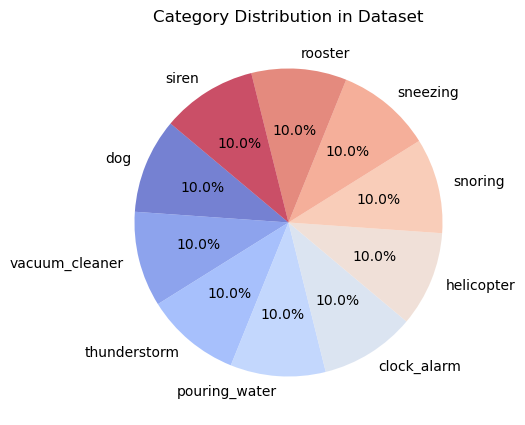

In [5]:
# Define categories of interest
categories = {
    'Animals': ['dog', 'rooster'],
    'Natural soundscapes & water sounds': ['thunderstorm', 'pouring_water'],
    'Human sounds': ['snoring', 'sneezing'],
    'Interior/domestic sounds': ['clock_alarm', 'vacuum_cleaner'],
    'Exterior/urban noises': ['siren', 'helicopter']
}

# Filter the dataframe to include only selected categories
selected_classes = sum(categories.values(), [])  # Flatten the list of classes
df_filtered = df[df['category'].isin(selected_classes)]  # Filter by category

# Check class balance
class_counts = df_filtered['category'].value_counts()
print("Class counts for selected categories:\n", class_counts)

if all(class_counts == 40):
    print("✅ All classes have 40 rows.")
else:
    print("❌ Some classes do not have 40 rows.")
    print("Classes with insufficient rows:\n", class_counts[class_counts != 40])

# Plot the category distribution
plt.figure(figsize=(5, 5))
df_filtered['category'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, cmap="coolwarm", wedgeprops={'alpha': 0.7})
plt.ylabel('')
plt.title("Category Distribution in Dataset")
plt.show()

## Category to Target Mapping  
Create a mapping from each sound category to its corresponding target number and display the mapping.

In [6]:
# Map each category to its target value
category_to_target = df_filtered.set_index('category')['target'].to_dict()

# Create and display the mapping as a DataFrame
mapping_df = pd.DataFrame(category_to_target.items(), columns=['Category', 'Target'])
print(mapping_df.to_string(index=False))

      Category  Target
           dog       0
vacuum_cleaner      36
  thunderstorm      19
 pouring_water      17
   clock_alarm      37
    helicopter      40
       snoring      28
      sneezing      21
       rooster       1
         siren      42


## Sound Sampling Verification  
Sample audio sounds by category and verify that all expected classes are represented. Display any missing or represented classes.

In [7]:
# Sample sounds by category and check for representation
sampled_sounds = sample_sounds_by_category(df, categories)

missing_classes = {}
represented_classes = {}

for category, expected_classes in categories.items():
    sampled_classes = set(df[df['filename'].isin(sampled_sounds[category])]['category'])
    
    # Track missing and represented classes
    missing = set(expected_classes) - sampled_classes
    represented_classes[category] = sampled_classes

    if missing:
        missing_classes[category] = missing

    print(f"Category: {category}, Sampled Classes: {sampled_classes}")

# Summary of results
print("\n✅ Represented Classes:")
for category, classes in represented_classes.items():
    print(f"- {category}: {classes}")

if missing_classes:
    print("\n❌ Missing Classes:")
    for category, classes in missing_classes.items():
        print(f"- {category}: {classes}")
else:
    print("\n🎉 All expected classes are present!")

Category: Animals, Sampled Classes: {'rooster', 'dog'}
Category: Natural soundscapes & water sounds, Sampled Classes: {'pouring_water', 'thunderstorm'}
Category: Human sounds, Sampled Classes: {'sneezing', 'snoring'}
Category: Interior/domestic sounds, Sampled Classes: {'vacuum_cleaner', 'clock_alarm'}
Category: Exterior/urban noises, Sampled Classes: {'siren', 'helicopter'}

✅ Represented Classes:
- Animals: {'rooster', 'dog'}
- Natural soundscapes & water sounds: {'pouring_water', 'thunderstorm'}
- Human sounds: {'sneezing', 'snoring'}
- Interior/domestic sounds: {'vacuum_cleaner', 'clock_alarm'}
- Exterior/urban noises: {'siren', 'helicopter'}

🎉 All expected classes are present!


## Waveform Data Loading  
Load sampled and full audio wave data, displaying basic statistics like sample rate and waveform shape.

In [8]:
# Load wave data for sampled and full dataset
wave_list_data_sampled = load_wave_data(sampled_sounds, audio_files_path)  # Load sampled sounds
wave_list_data = load_all_sounds(df, categories, audio_files_path)  # Load all sounds

# Display basic statistics
print("Total samples loaded:", len(wave_list_data))
print("Example sample rate:", wave_list_data[0][2])
print("Example waveform shape:", wave_list_data[0][3].shape)

Total samples loaded: 400
Example sample rate: 44100
Example waveform shape: (220500,)


## Feature Extraction and Saving  
If enabled, extract multiple audio features from the wave data and save them in a compressed file.

In [9]:
if compute_features:
    # Extract multiple audio features
    keys_list, mfcc_list, delta_mfcc_list, hist_list, spectral_centroid_list, spectral_contrast_list, pitch_features_list, zcr_list, envelope_list, hnr_list = compute_features_for_wave_list(wave_list_data)

    # Save extracted features to a compressed NPZ file
    save_multiple_features_to_npz(
        keys_list, 
        mfcc_list, 
        delta_mfcc_list,
        hist_list, 
        spectral_centroid_list,
        spectral_contrast_list,
        pitch_features_list, 
        zcr_list, 
        envelope_list, 
        hnr_list, 
        out_file="features/extracted_features_multiple_test.npz"
    )

## Load Extracted Features  
Load saved audio features from the compressed NPZ file and display the available keys for verification.

In [10]:
# Load saved audio features from NPZ file
loaded_data = np.load("features/extracted_features_multiple_test.npz")

# Define which features to include (enable/disable specific features)
feature_selection = {
    'mfcc': True,
    'delta_mfcc': True,
    'hist': True,
    'spectral_centroid': True,
    'spectral_contrast': True,
    'pitch_features': True,
    'zcr': True,
    'envelope': True,
    'hnr': True
}

# Display available keys in the loaded file
print("Available keys in the loaded .npz file:", loaded_data.files)

Available keys in the loaded .npz file: ['keys', 'mfcc', 'delta_mfcc', 'hist', 'spectral_centroid', 'spectral_contrast', 'pitch_features', 'zcr', 'envelope', 'hnr']


## Display Feature Details and Combine Selected Features  
Print the shape of each feature and check if it is selected. Combine selected features into a single feature matrix for further analysis.

In [11]:
# Display feature shapes and selection status
print("Feature shapes and selection status:")
for feature, include in feature_selection.items():
    shape = loaded_data[feature].shape
    status = "✅" if include else "❌"
    print(f"{feature.capitalize()} shape: {shape} - Status: {status}")

# Extract features and labels from the loaded dataset
keys_list = loaded_data['keys']
mfcc_features = loaded_data['mfcc']
delta_mfcc_features = loaded_data['delta_mfcc']
hist_features = loaded_data['hist']
spectral_centroid_features = loaded_data['spectral_centroid']
spectral_contrast_features = loaded_data['spectral_contrast']
pitch_features = loaded_data['pitch_features']
zcr_features = loaded_data['zcr']
envelope_features = loaded_data['envelope']
hnr_features = loaded_data['hnr']

# Define combinations for each feature type
feature_combinations = {
    'mfcc': mfcc_features,
    'delta_mfcc': delta_mfcc_features,
    'hist': hist_features,
    'spectral_centroid': spectral_centroid_features,
    'spectral_contrast': spectral_contrast_features,
    'pitch_features': pitch_features,
    'zcr': zcr_features,
    'envelope': envelope_features,
    'hnr': hnr_features
}

# Combine features using selected flags
combined_features = combine_features_with_flags(loaded_data, feature_selection)

Feature shapes and selection status:
Mfcc shape: (400, 13) - Status: ✅
Delta_mfcc shape: (400, 13) - Status: ✅
Hist shape: (400, 80) - Status: ✅
Spectral_centroid shape: (400, 2) - Status: ✅
Spectral_contrast shape: (400, 16) - Status: ✅
Pitch_features shape: (400, 2) - Status: ✅
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅
Combined feature shape: (400, 134)


## Analyze Feature Relationships and Class Contributions  
1. Create a DataFrame with feature means and class labels.  
2. Compute and visualize the correlation between features using a heatmap.  
3. Analyze class-wise feature contributions using the mean feature values for each class.

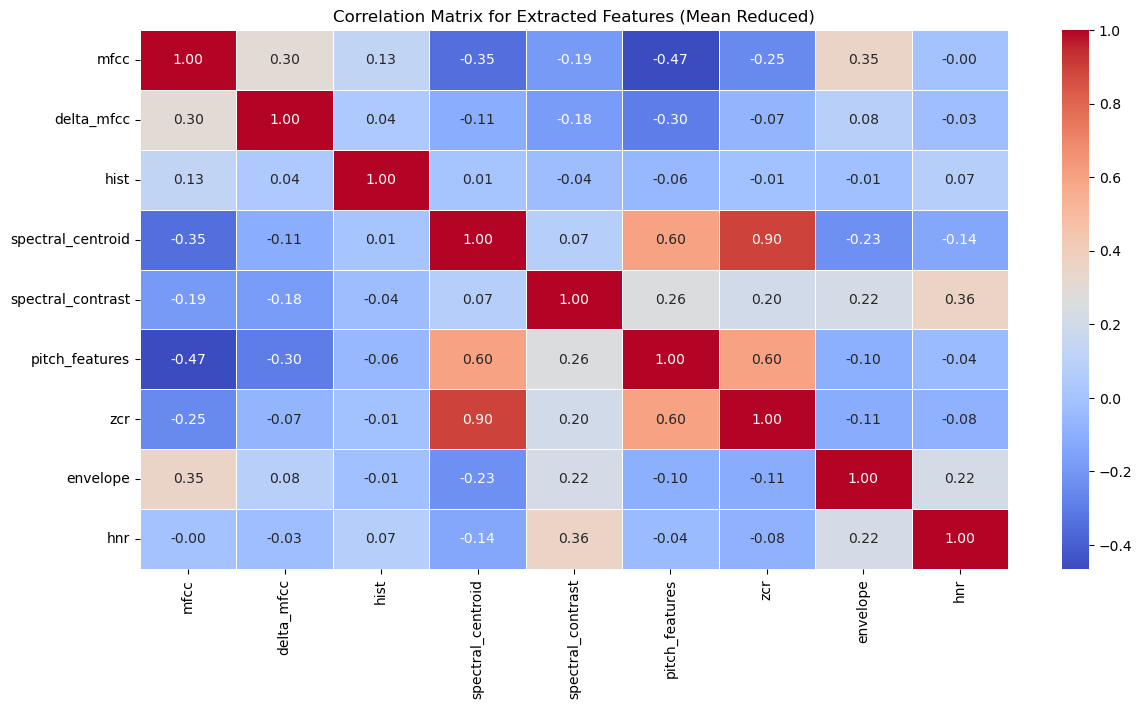

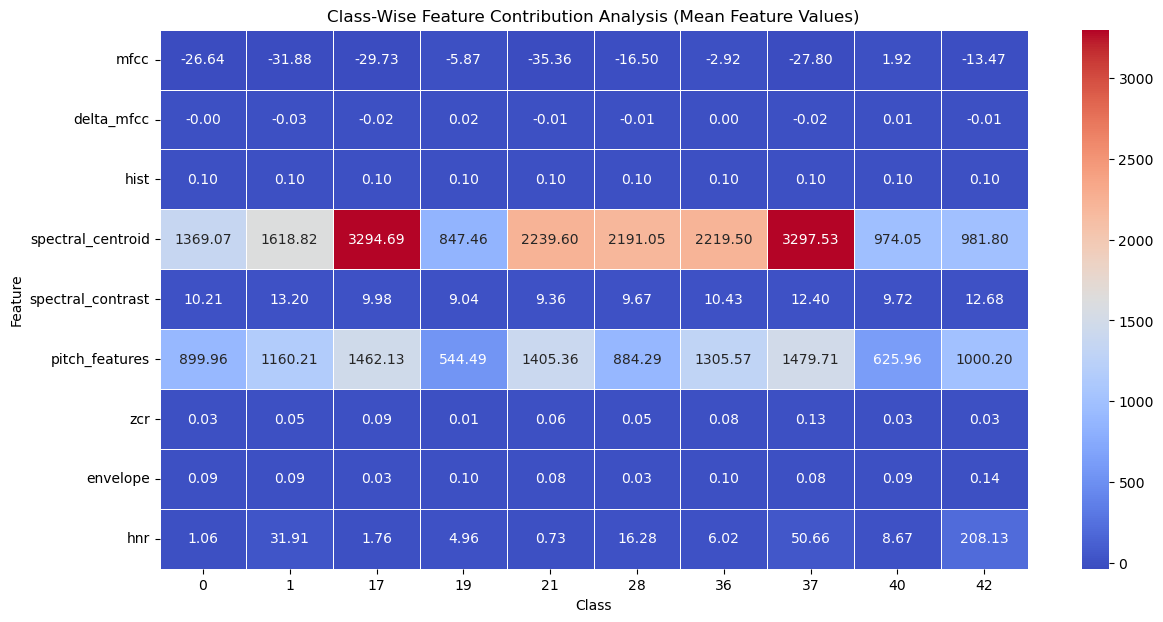

In [12]:
# Create a DataFrame for feature means
df_features = pd.DataFrame()

# Compute mean of multi-dimensional features or use directly if 1D
for feature in feature_selection:
    if feature in loaded_data:
        feature_data = loaded_data[feature]
        df_features[feature] = feature_data.mean(axis=1) if feature_data.ndim > 1 else feature_data

# Add class labels to the DataFrame
df_features["Class"] = keys_list

# Compute and plot the correlation matrix
correlation_matrix = df_features.drop(columns=["Class"]).corr()
plt.figure(figsize=(14, 7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix for Extracted Features (Mean Reduced)")
plt.show()

# Compute class-wise mean feature values
df_mean_features = df_features.groupby("Class").mean()

# Plot class-wise feature contributions
plt.figure(figsize=(14, 7))
sns.heatmap(df_mean_features.T, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Class-Wise Feature Contribution Analysis (Mean Feature Values)")
plt.xlabel("Class")
plt.ylabel("Feature")
plt.show()

## Feature Groups for Model Evaluation  
Defines different groups of feature combinations, each tailored to specific types of analysis such as temporal, harmonic, noise, and spectral features. These groups will be used for model training and evaluation.

In [13]:
feature_groups_selection = {
    'group_1_temporal': {'mfcc': False, 'delta_mfcc': True, 'hist': False, 'spectral_centroid': False, 
                         'spectral_contrast': False, 'pitch_features': False, 'zcr': True, 
                         'envelope': True, 'hnr': False},
    
    'group_2_harmonic': {'mfcc': True, 'delta_mfcc': False, 'hist': False, 'spectral_centroid': False, 
                         'spectral_contrast': False, 'pitch_features': True, 'zcr': False, 
                         'envelope': False, 'hnr': True},
    
    'group_3_spectral_brightness': {'mfcc': True, 'delta_mfcc': False, 'hist': False, 'spectral_centroid': True, 
                                    'spectral_contrast': True, 'pitch_features': False, 'zcr': False, 
                                    'envelope': False, 'hnr': False},
    
    'group_4_noise': {'mfcc': False, 'delta_mfcc': False, 'hist': True, 'spectral_centroid': False, 
                      'spectral_contrast': True, 'pitch_features': False, 'zcr': False, 
                      'envelope': False, 'hnr': True},
    
    'group_5_general_1': {'mfcc': True, 'delta_mfcc': True, 'hist': False, 'spectral_centroid': False, 
                          'spectral_contrast': False, 'pitch_features': False, 'zcr': True, 
                          'envelope': True, 'hnr': False},
    
    'group_6_general_2': {'mfcc': True, 'delta_mfcc': False, 'hist': False, 'spectral_centroid': True, 
                          'spectral_contrast': True, 'pitch_features': True, 'zcr': False, 
                          'envelope': False, 'hnr': False},
    
    'group_7_general_composite': {'mfcc': True, 'delta_mfcc': True, 'hist': False, 'spectral_centroid': True, 
                                  'spectral_contrast': True, 'pitch_features': True, 'zcr': True, 
                                  'envelope': True, 'hnr': True}
}

## Dynamic Feature Group Analysis with Subplots  
Iterate through each feature group, compute correlation matrices, and visualize them .

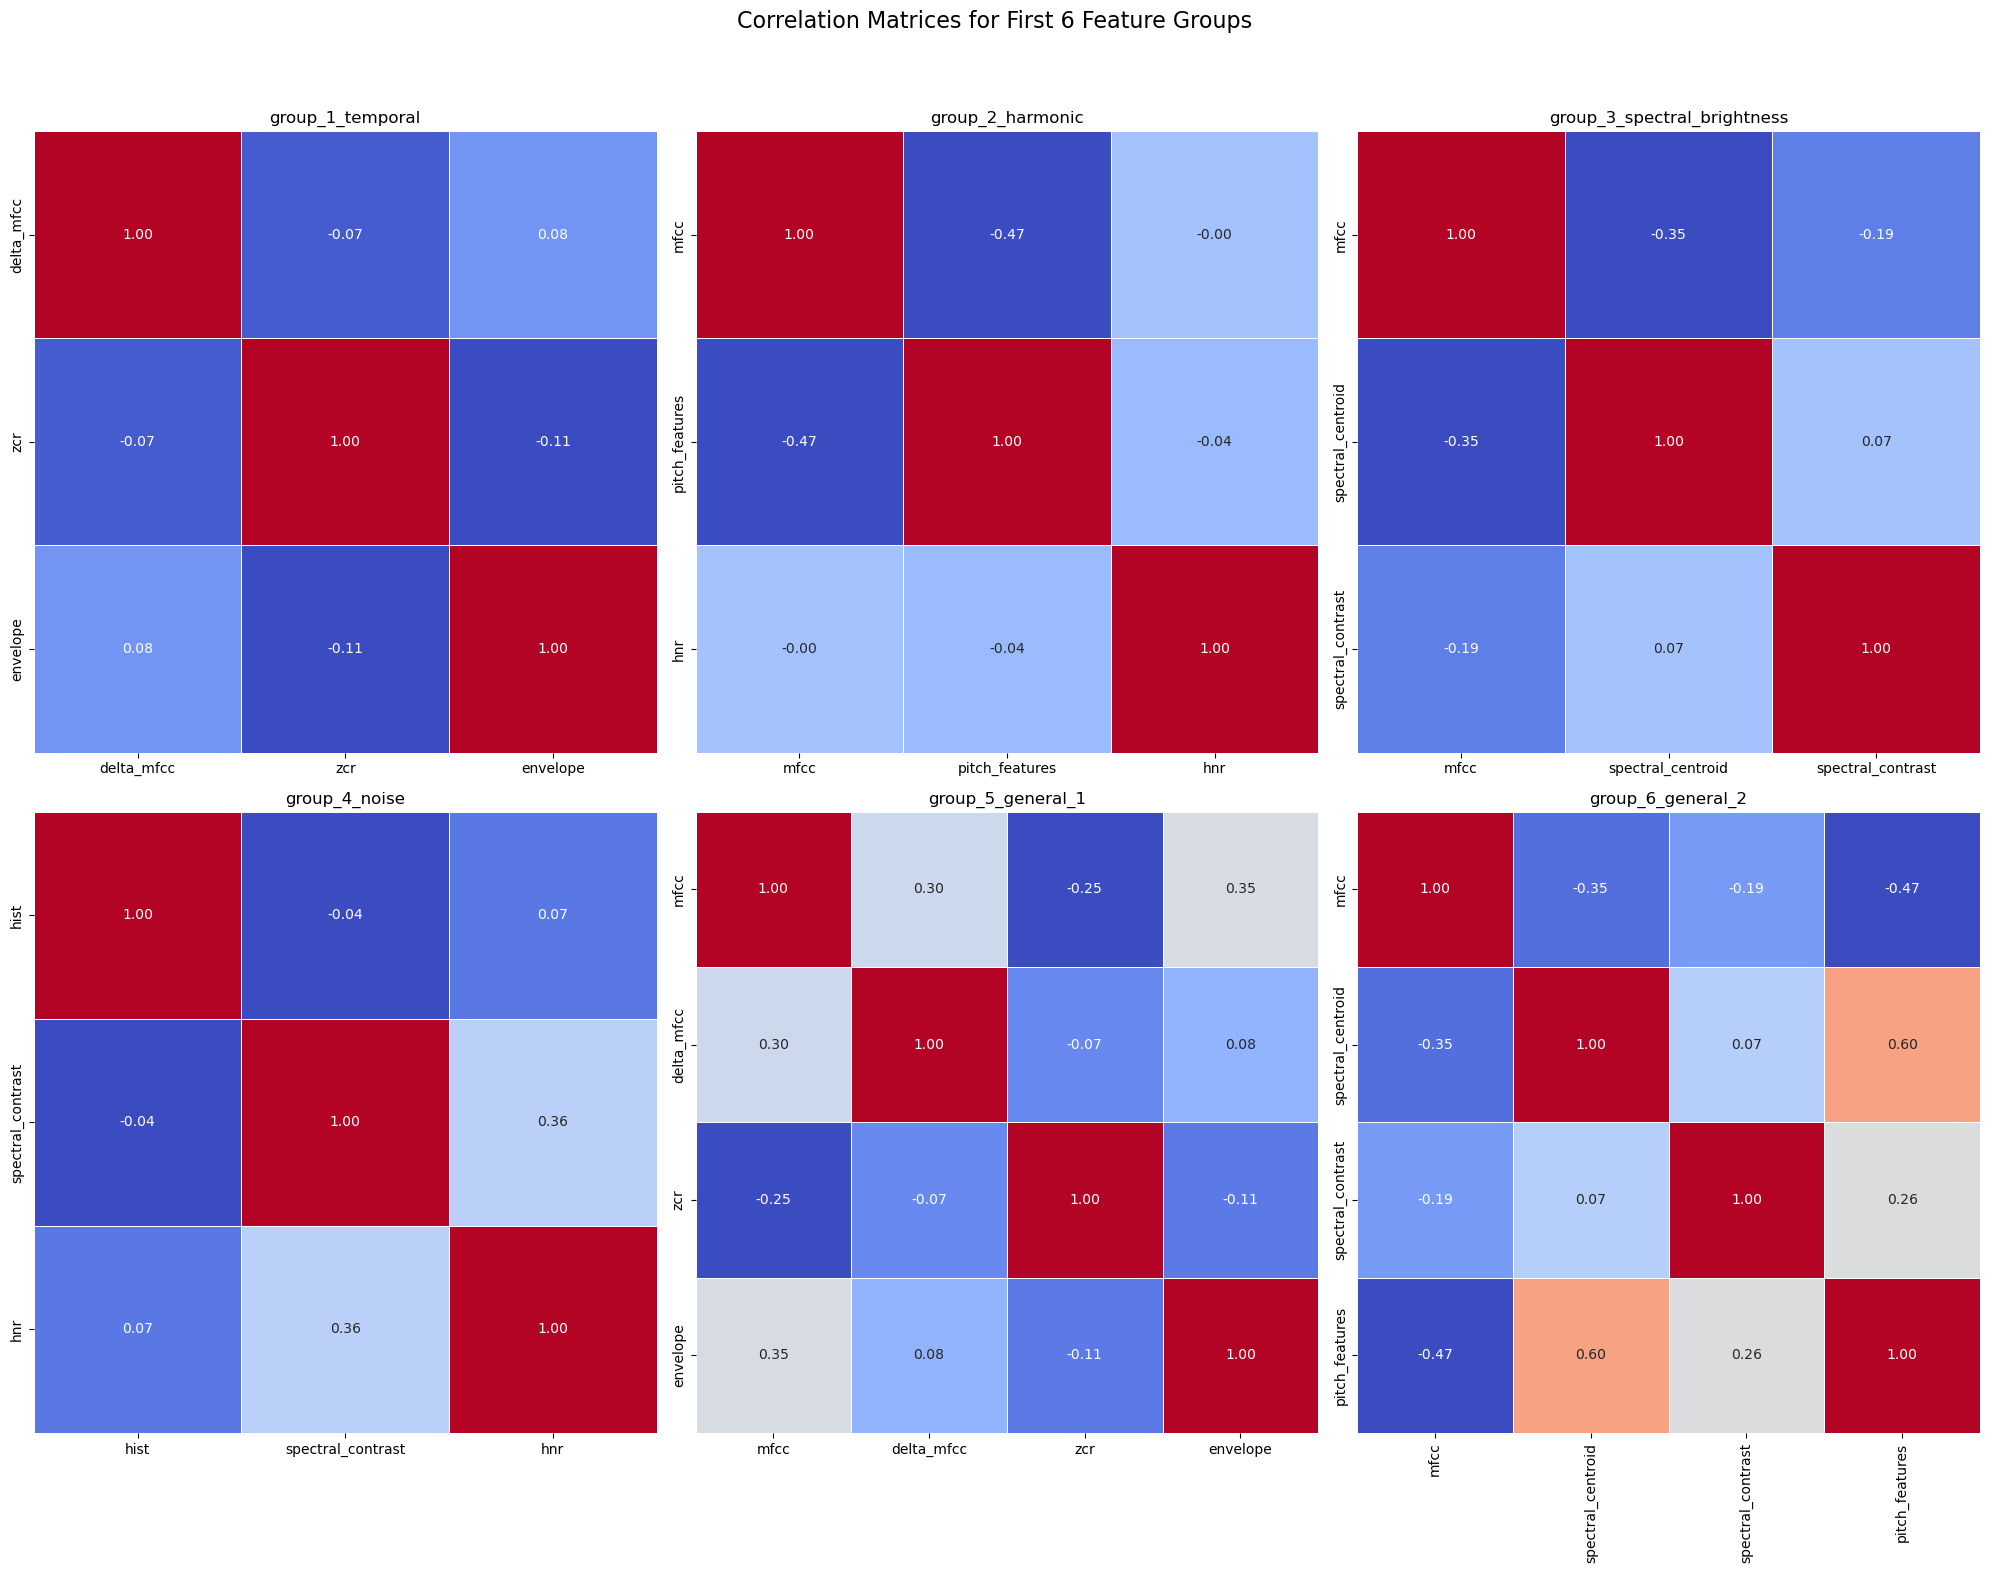

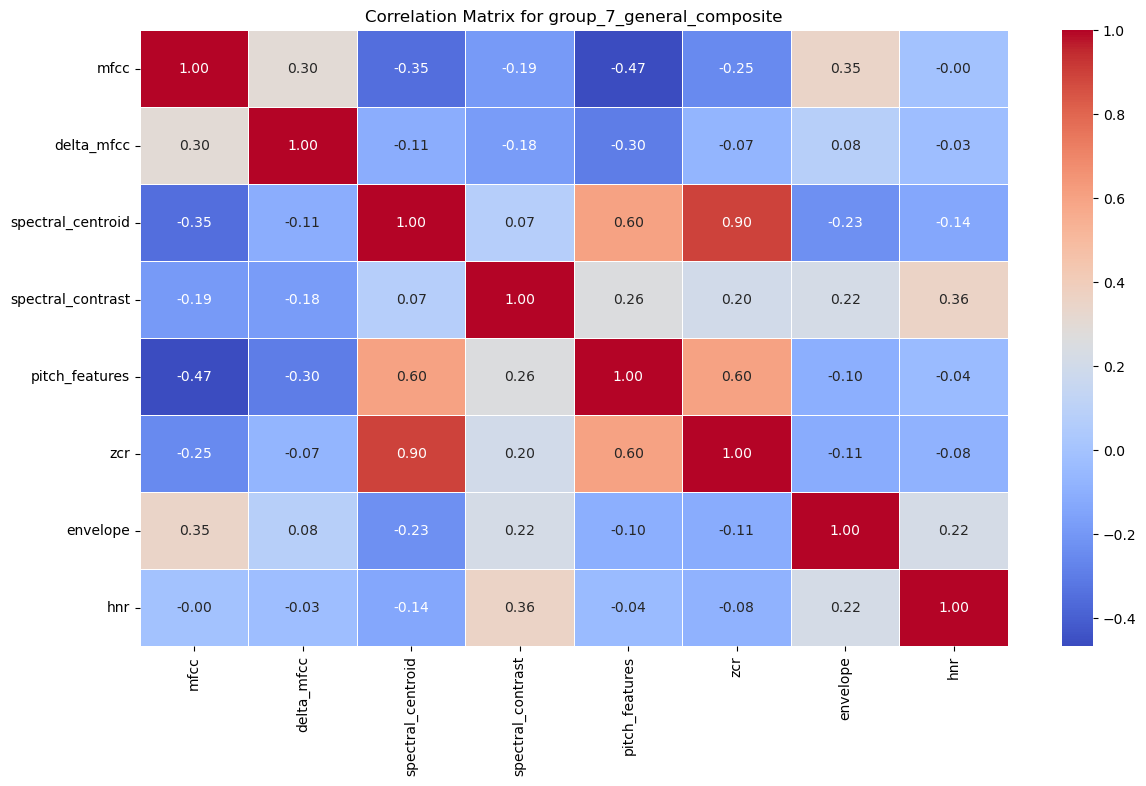

In [14]:
# Initialize the subplot grid for the first 6 groups
fig, axes = plt.subplots(2, 3, figsize=(20, 16))
fig.suptitle("Correlation Matrices for First 6 Feature Groups", fontsize=16)
axes = axes.flatten()

# Iterate through the first 6 feature groups
for idx, (group_name, feature_selection) in enumerate(list(feature_groups_selection.items())[:6]):
    df_features = pd.DataFrame()

    # Collect selected features
    for feature, selected in feature_selection.items():
        if selected and feature in loaded_data:
            feature_data = loaded_data[feature]
            df_features[feature] = feature_data.mean(axis=1) if feature_data.ndim > 1 else feature_data

    # Add class labels and compute correlation matrix
    df_features["Class"] = keys_list  
    correlation_matrix = df_features.drop(columns=["Class"]).corr()

    # Plot the heatmap in the respective subplot
    sns.heatmap(
        correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
        linewidths=0.5, ax=axes[idx], cbar=False
    )
    axes[idx].set_title(f"{group_name}")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Plot the 7th feature group separately
group_name, feature_selection = list(feature_groups_selection.items())[6]
df_features = pd.DataFrame()

# Collect selected features for the last group
for feature, selected in feature_selection.items():
    if selected and feature in loaded_data:
        feature_data = loaded_data[feature]
        df_features[feature] = feature_data.mean(axis=1) if feature_data.ndim > 1 else feature_data

# Add class labels and compute correlation matrix
df_features["Class"] = keys_list  
correlation_matrix = df_features.drop(columns=["Class"]).corr()

# Plot heatmap for the last group
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title(f"Correlation Matrix for {group_name}")
plt.show()

### **Display Selected Features and Component Totals**
Iterate through feature groups to display selected features and their total component count.

In [15]:
# Call the function to print the groups
print_feature_groups_with_totals(feature_groups_selection, loaded_data)


🔍 Feature Group: group_1_temporal | Total Features: 20 components
Selected Features: delta_mfcc (13 components), zcr (2 components), envelope (5 components)

🔍 Feature Group: group_2_harmonic | Total Features: 16 components
Selected Features: mfcc (13 components), pitch_features (2 components), hnr (1 components)

🔍 Feature Group: group_3_spectral_brightness | Total Features: 31 components
Selected Features: mfcc (13 components), spectral_centroid (2 components), spectral_contrast (16 components)

🔍 Feature Group: group_4_noise | Total Features: 97 components
Selected Features: hist (80 components), spectral_contrast (16 components), hnr (1 components)

🔍 Feature Group: group_5_general_1 | Total Features: 33 components
Selected Features: mfcc (13 components), delta_mfcc (13 components), zcr (2 components), envelope (5 components)

🔍 Feature Group: group_6_general_2 | Total Features: 33 components
Selected Features: mfcc (13 components), spectral_centroid (2 components), spectral_contr

# **Section 2: Support Vector Machines (SVM)**

### **Train-Test Splitting**
Split the combined features and labels into training and testing sets using an 80-20 split while maintaining class distribution.

In [16]:
# Train-Test Splitting
X = combined_features
y = np.array(keys_list)

# Perform train-test split (80-20) with stratification
X_train_not_scaled, X_test_not_scaled, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=keys_list
)

### **Feature Normalization Using Z-Score (StandardScaler)**
Apply Z-score normalization to both the training and testing sets using the mean and standard deviation calculated from the training data.

In [17]:
# Initialize StandardScaler for Z-score normalization
scaler = StandardScaler()

# Normalize train and test features using training data statistics
X_train = scaler.fit_transform(X_train_not_scaled)  # Fit on training data
X_test = scaler.transform(X_test_not_scaled)        # Transform test data using train's mean and std

### **Train and Test Set Overview**
Displays the sizes of train and test sets, lists unique classes, and provides a detailed breakdown of class distribution in both sets.

In [18]:
# Display train and test set sizes
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Show unique classes before splitting
unique_classes = set(keys_list)
print("Unique classes in dataset before splitting:", unique_classes)

# Count class occurrences in train and test sets
train_counts = pd.Series(y_train).value_counts()
test_counts = pd.Series(y_test).value_counts()

# Merge counts into a table
df_counts = pd.DataFrame({'Train': train_counts, 'Test': test_counts}).fillna(0).astype(int)

# Display class distribution table and summary
print("\nClass Distribution Table:")
print(df_counts.to_string())
print("\nSummary:")
print(f"Total samples in Train set: {df_counts['Train'].sum()}")
print(f"Total samples in Test set: {df_counts['Test'].sum()}")

Training set size: (320, 134)
Test set size: (80, 134)
Unique classes in dataset before splitting: {0, 1, 36, 37, 40, 42, 17, 19, 21, 28}

Class Distribution Table:
    Train  Test
0      32     8
1      32     8
17     32     8
19     32     8
21     32     8
28     32     8
36     32     8
37     32     8
40     32     8
42     32     8

Summary:
Total samples in Train set: 320
Total samples in Test set: 80


### **SVM Hyperparameter Tuning**
Performs grid search to find the best hyperparameters for the SVM classifier using training data.

In [19]:
param_grid_svm = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 'scale', 10, 100],
    'kernel': ['rbf', 'linear']
}

# Grid search for optimal SVM parameters
grid_search_svm, best_params_svm, best_score_svm = grid_search_hyperparameter_tuning(
    model=SVC(probability=True, random_state=42),
    param_grid=param_grid_svm,
    X_train=X_train,
    y_train=y_train
)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best roc_auc_ovr Score: 0.9890


### **Heatmap of AUC Scores for SVM Hyperparameters**
Displays a heatmap of AUC scores obtained from cross-validation, showing the effect of different combinations of `C` and `gamma` values on model performance.

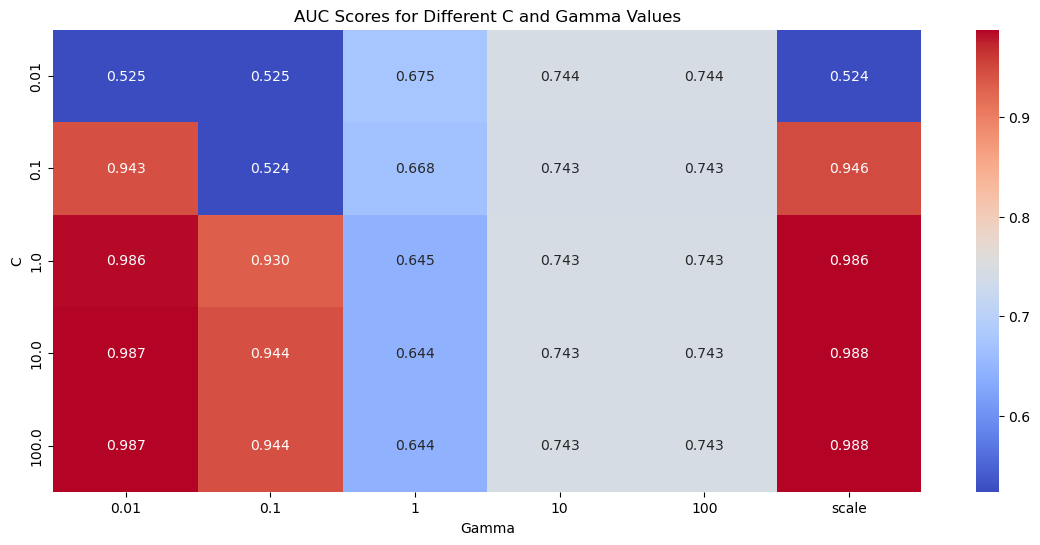

In [20]:
# Convert grid search results to DataFrame
cv_results = pd.DataFrame(grid_search_svm.cv_results_)

# Ensure correct sorting by converting parameters to appropriate types
cv_results["param_C"] = cv_results["param_C"].astype(float)
cv_results["param_gamma"] = cv_results["param_gamma"].astype(str)  # Gamma can include 'scale'

# Create pivot table for AUC scores
df_heatmap = cv_results.pivot_table(index="param_C", columns="param_gamma", values="mean_test_score", aggfunc="mean")
df_heatmap = df_heatmap.sort_index(ascending=True)  # Sort C values for clarity

# Plot heatmap of AUC scores
plt.figure(figsize=(14, 6))
sns.heatmap(df_heatmap, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("AUC Scores for Different C and Gamma Values")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.show()

### **SVM Classifier Evaluation with Best Hyperparameters**
Trains the SVM using optimal hyperparameters, evaluates performance using AUC, accuracy, and classification report, and visualizes the confusion matrix.


AUC on the test set: 0.9894097222222221

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       1.00      0.88      0.93         8
          17       0.88      0.88      0.88         8
          19       0.64      0.88      0.74         8
          21       0.80      1.00      0.89         8
          28       1.00      0.88      0.93         8
          36       0.89      1.00      0.94         8
          37       0.73      1.00      0.84         8
          40       0.75      0.38      0.50         8
          42       1.00      1.00      1.00         8

    accuracy                           0.85        80
   macro avg       0.87      0.85      0.84        80
weighted avg       0.87      0.85      0.84        80


Accuracy on the test set: 0.85


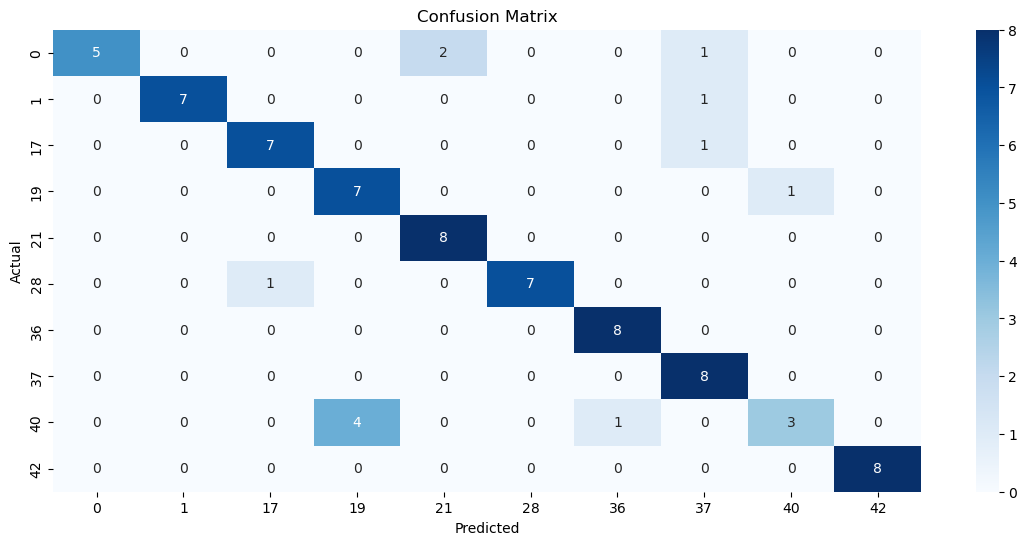

In [21]:
# Train SVM using best hyperparameters
svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm.fit(X_train, y_train)

# Make predictions and calculate probabilities
y_pred = svm.predict(X_test)
y_prob = svm.predict_proba(X_test)

# Evaluate AUC
test_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("\nAUC on the test set:", test_auc)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix and accuracy
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy on the test set:", accuracy)

# Plot confusion matrix
plt.figure(figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **Multi-class ROC Curve Visualization**
Plots the ROC curves for each class using One-vs-Rest (OvR) classification and calculates the corresponding AUC values.

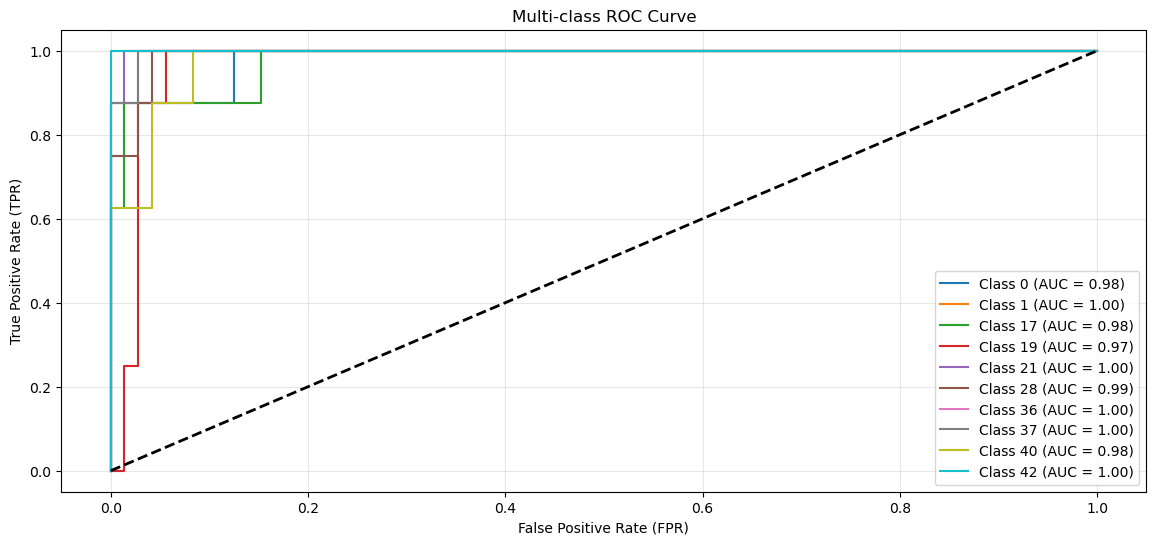

In [22]:
# Binarize the labels for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))

# Initialize plot
plt.figure(figsize=(14, 6))

# Compute and plot ROC curve and AUC for each class
for i in range(len(np.unique(y_test))):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {np.unique(y_test)[i]} (AUC = {roc_auc:.2f})')

# Plot configuration
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-class ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

### **Dimensionality Reduction using PCA**
Reduces features to 30 dimensions using PCA while retaining 80% of the variance. Displays the explained variance ratio and new feature shape.

In [23]:
# Reduce features using PCA retaining 80% variance
pca = PCA(n_components=0.8)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Output the variance ratio and the shape of reduced features
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Reduced feature shape:", X_train_pca.shape)

Explained variance ratio: [0.19509209 0.08515698 0.07228955 0.05691698 0.04521919 0.03602601
 0.03333351 0.03017803 0.02560287 0.02305684 0.02101277 0.01755981
 0.01651567 0.01617374 0.01493781 0.01432483 0.01374819 0.01357472
 0.01244197 0.01181433 0.0112548  0.01099488 0.0103654  0.00963513
 0.0094624 ]
Reduced feature shape: (320, 25)


### **SVM Classification with PCA-Reduced Features**
Trains an SVM classifier on the PCA-reduced training set and evaluates it using the test set. Computes AUC, a classification report, and visualizes the confusion matrix.


AUC on the test set: 0.986111111111111

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.89      1.00      0.94         8
          17       0.83      0.62      0.71         8
          19       0.64      0.88      0.74         8
          21       0.73      1.00      0.84         8
          28       0.67      0.75      0.71         8
          36       0.88      0.88      0.88         8
          37       1.00      1.00      1.00         8
          40       0.80      0.50      0.62         8
          42       1.00      1.00      1.00         8

    accuracy                           0.82        80
   macro avg       0.84      0.82      0.82        80
weighted avg       0.84      0.82      0.82        80



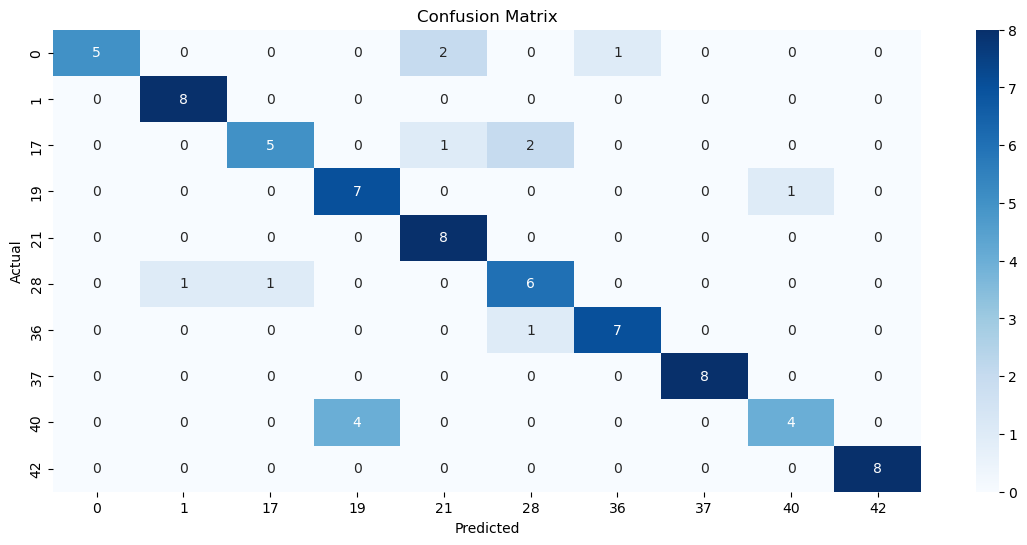

In [24]:
# Train SVM classifier on PCA-reduced features
svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
svm.fit(X_train_pca, y_train)

# Evaluate the classifier
y_pred = svm.predict(X_test_pca)
y_prob = svm.predict_proba(X_test_pca)

# Calculate AUC on the test set
test_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("\nAUC on the test set:", test_auc)

# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **Feature Combinations Testing with SVM**
Tests different feature combinations using SVM with specified hyperparameters. Normalizes the features, applies PCA, and displays the top 5 results.

In [25]:
if compute_features_comination_svm:
    results = test_feature_combinations(
        combinations_dict=feature_combinations,       # Dictionary of feature sets to combine
        y=y,                                          # Target labels
        model=SVC(),                                  # SVM classifier
        model_name="SVM",                             # For display purposes
        model_params={                                # SVM configuration
            'kernel': 'rbf',                          # Radial basis function kernel
            'C': 1,                                   # Regularization parameter
            'gamma': 'scale',                         # Kernel coefficient
            'probability': True,                      # Enable probability estimates
            'random_state': 42                        # Ensure reproducibility
        },
        n_splits=5,                                   # Number of K-Folds for cross-validation
        normalize=True,                               # Enable Z-score normalization
        apply_pca=True,                               # Apply PCA to reduce dimensions
        n_pca_components=0.9,                         # Retain 90% of explained variance
        overfit_threshold=0.15,                       # Threshold to detect overfitting
        use_gridsearch=False,                         # Skip grid search
        hyperparameter_grid=None,                     # No grid search params needed here
        top_k_results=5,                              # Display the top 5 results
        verbose=False                                 # Minimize detailed output
    )

### **Display Top 5 Non-Overfitted Combinations**
- Filter results to display the top 5 non-overfitted combinations with exactly 3 features, sorted by their combined score.

In [26]:
if compute_features_comination_svm:
    # Filter for combinations with exactly 3 features and no overfitting
    top_5_results_length_lim = [
        res for res in results 
        if len(res['combination']) == 3 and res['overfitting_status'] == "✅ No Overfitting"
    ]
    # Sort by combined score in descending order
    top_5_results_length_lim.sort(key=lambda x: x['combined_score'], reverse=True)

    # Display the top 5 results
    print("\nTop 5 Non-Overfitted Combinations with Exactly 3 Features:")
    for res in top_5_results_length_lim[:5]:
        print(f"Combination: {res['combination']}, AUC: {res['average_auc']:.4f}, "
              f"Val Accuracy: {res['average_val_accuracy']:.4f}, Overfitting: {res['overfitting_status']}")

### **Visualize Top 5 Non-Overfitted Combinations  **
Plot the accuracy and AUC scores of the top 5 non-overfitted feature combinations using a bar chart and line plot.

In [27]:
if compute_features_comination_svm:
    # Extract feature names, accuracies, and AUC scores
    feature_names = ["_".join(res['combination']) for res in top_5_results_length_lim[:5]]
    accuracies = [res['average_val_accuracy'] for res in top_5_results_length_lim[:5]]
    auc_scores = [res['average_auc'] for res in top_5_results_length_lim[:5]]

    # Create plot
    fig, ax1 = plt.subplots(figsize=(14, 6))
    colors = sns.color_palette("Blues", len(feature_names))

    # Plot accuracy as bars
    ax1.bar(feature_names, accuracies, color=colors, alpha=0.7, label='Accuracy')
    ax1.set_ylabel('Accuracy', color='b')
    ax1.set_ylim(0.5, 1.0)
    plt.xticks(rotation=30, ha="right", fontsize=10)
    ax1.grid(axis='y', linestyle='--', alpha=0.5)

    # Plot AUC as a line
    ax2 = ax1.twinx()
    ax2.plot(feature_names, auc_scores, color='r', marker='o', linestyle='-', linewidth=2, markersize=8, label='AUC')
    ax2.set_ylabel('AUC Score', color='r')
    ax2.set_ylim(0.5, 1.0)

    # Formatting and legends
    plt.title("SVM Performance on Top 5 Feature Combinations", fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)

    # Show plot
    plt.show()

### Feature Selection and Data Splitting  
Select audio features for the model and split the dataset into training and test sets.

In [28]:
feature_selection = {
    'mfcc': True,
    'delta_mfcc': True,
    'hist': True,
    'spectral_centroid': True,
    'spectral_contrast': True,
    'pitch_features': True,
    'zcr': True,
    'envelope': True,
    'hnr': True
}

# Load and split features into training and test sets
selected_features, X_train, X_test, y_train, y_test, selected_features_names = load_and_split_features(
    loaded_data, feature_selection
)

Combined feature shape: (400, 134)
Feature shapes and selection status:
Mfcc shape: (400, 13) - Status: ✅
Delta_mfcc shape: (400, 13) - Status: ✅
Hist shape: (400, 80) - Status: ✅
Spectral_centroid shape: (400, 2) - Status: ✅
Spectral_contrast shape: (400, 16) - Status: ✅
Pitch_features shape: (400, 2) - Status: ✅
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 134)


### SVM with K-Fold Cross-Validation  
Train the SVM model using 5-fold cross-validation, applying normalization and optional PCA, while detecting potential overfitting.

In [29]:
svm_results = kfold_cross_validation(
    features=selected_features,                         # Selected feature set
    labels=y,                                           # Target labels
    selected_features_names=selected_features_names,    # Names of the selected features
    model=SVC(probability=True),                        # SVM model with probability estimates enabled
    model_params={'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01, 'random_state': 42},  # SVM hyperparameters
    n_splits=5,                                         # Number of K-Folds for cross-validation
    preprocess_params={'normalize': True, 'apply_pca': False, 'n_pca_components': 0.9},  # Normalization and PCA settings
    overfit_threshold=0.1                               # Threshold to identify overfitting
)


Settings:
 - Selected Features: mfcc, delta_mfcc, hist, spectral_centroid, spectral_contrast, pitch_features, zcr, envelope, hnr
 - Model: SVC
 - Model Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01, 'random_state': 42}
 - Preprocessing: {'normalize': True, 'apply_pca': False, 'n_pca_components': 0.9}


[Fold 1]
   - Train Accuracy: 0.9781, Test Accuracy: 0.8250
   - AUC: 0.9786
   - Precision: 0.8516, Recall: 0.8250, F1-score: 0.8243

[Fold 2]
   - Train Accuracy: 0.9656, Test Accuracy: 0.8625
   - AUC: 0.9913
   - Precision: 0.8807, Recall: 0.8625, F1-score: 0.8652

[Fold 3]
   - Train Accuracy: 0.9719, Test Accuracy: 0.8250
   - AUC: 0.9925
   - Precision: 0.8317, Recall: 0.8250, F1-score: 0.8192

[Fold 4]
   - Train Accuracy: 0.9781, Test Accuracy: 0.8375
   - AUC: 0.9816
   - Precision: 0.8609, Recall: 0.8375, F1-score: 0.8404

[Fold 5]
   - Train Accuracy: 0.9750, Test Accuracy: 0.7750
   - AUC: 0.9778
   - Precision: 0.8189, Recall: 0.7750, F1-score: 0.7763

K-Fold Summa

### **SVM Evaluation Across Feature Groups**  
The SVM classifier is evaluated using 5-fold cross-validation with the following settings:  
- **Kernel:** Radial basis function (rbf)  
- **C (Regularization):** 1.0  
- **Gamma:** 0.01  
- **Preprocessing:** Z-score normalization, PCA disabled  
- **Overfitting Detection Threshold:** 0.1  
- **Evaluation:** Performance metrics, including classification accuracy and overfitting detection, are assessed across different feature groups.

In [30]:
svm_params = {
    'kernel': 'rbf',    # Radial basis function kernel
    'C': 1.0,           # Regularization strength
    'gamma': 0.01,      # Kernel coefficient
    'random_state': 42  # Ensure reproducibility
}

kfold_params = {
    'n_splits': 5,              # Number of cross-validation folds
    'preprocess_params': {'normalize': True, 'apply_pca': False, 'n_pca_components': 0.9},  # Preprocessing settings
    'overfit_threshold': 0.1    # Overfitting detection threshold
}

print("\nRunning SVM")
svm_results_df = run_classifier_on_feature_groups(
    feature_groups_selection=feature_groups_selection,  # Feature groups for evaluation
    loaded_data=loaded_data,                            # Loaded features
    y=y,                                                # Target labels
    classifier=SVC(probability=True),                   # SVM classifier
    classifier_params=svm_params,                       # SVM hyperparameters
    kfold_params=kfold_params,                          # K-fold cross-validation settings
    plot_boxplots=False,                                # Disable boxplot visualization
    plot_confusion_matrix=False,                        # Disable confusion matrix visualization
    display_iteration_details=False,                    # Suppress iteration details
    display_classification_report=True                  # Display the classification report
)


Running SVM

🔄 Running SVC on Feature Group: group_1_temporal
Selected features in this group: ['delta_mfcc', 'zcr', 'envelope']
Combined feature shape: (400, 20)
Feature shapes and selection status:
Mfcc shape: (400, 13) - Status: ❌
Delta_mfcc shape: (400, 13) - Status: ✅
Hist shape: (400, 80) - Status: ❌
Spectral_centroid shape: (400, 2) - Status: ❌
Spectral_contrast shape: (400, 16) - Status: ❌
Pitch_features shape: (400, 2) - Status: ❌
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ❌

Combined features shape: (400, 20)
Combined features shape: (400, 20)

Settings:
 - Selected Features: delta_mfcc, zcr, envelope
 - Model: SVC
 - Model Parameters: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01, 'random_state': 42}
 - Preprocessing: {'normalize': True, 'apply_pca': False, 'n_pca_components': 0.9}


K-Fold Summary:
 - Average Train Accuracy: 0.6256
 - Average Test Accuracy: 0.5175
 - Average AUC: 0.8964
 - Average TPR: 0.5175
 - Average F

---
---

# Section 3: Random Forest Classifier  (RF)
We now transition to evaluating the performance of the Random Forest classifier.

# Loading Features and Preparing Train-Test Split  
This section loads the saved features from the compressed file, selects specific features based on the defined configuration, and splits the data into training and testing sets for further evaluation.

In [31]:
# Load saved features
loaded_data = np.load("features/extracted_features_multiple_test.npz")

# Define features to include for model evaluation
feature_selection = {
    'mfcc': True,
    'delta_mfcc': True,
    'hist': True,
    'spectral_centroid': True,
    'spectral_contrast': True,
    'pitch_features': True,
    'zcr': True,
    'envelope': True,
    'hnr': True
}

# Split selected features into training and testing sets
selected_features, X_train, X_test, y_train, y_test, selected_features_names = load_and_split_features(
    loaded_data, feature_selection
)

Combined feature shape: (400, 134)
Feature shapes and selection status:
Mfcc shape: (400, 13) - Status: ✅
Delta_mfcc shape: (400, 13) - Status: ✅
Hist shape: (400, 80) - Status: ✅
Spectral_centroid shape: (400, 2) - Status: ✅
Spectral_contrast shape: (400, 16) - Status: ✅
Pitch_features shape: (400, 2) - Status: ✅
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 134)


### **Hyperparameter Tuning for Random Forest**
This section performs hyperparameter tuning using GridSearchCV with Stratified K-Fold cross-validation to optimize the Random Forest classifier. A heatmap is plotted to visualize the AUC scores across combinations of max depth and min samples split.

Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 100}


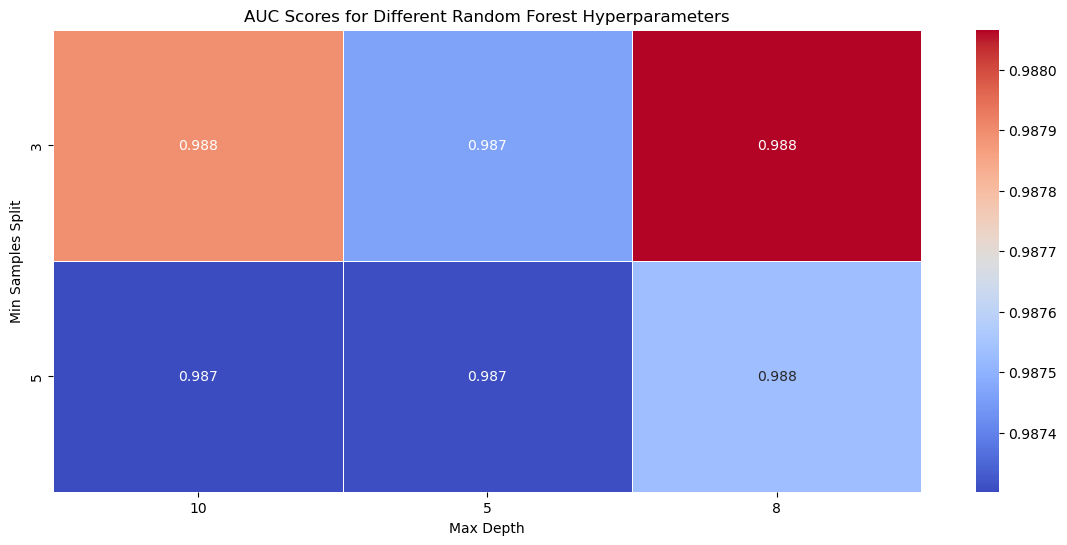

In [32]:
# Define Stratified K-Fold for balanced class distribution in each fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],     # Number of trees in the forest
    'max_depth': [5, 8, 10],            # Depth of the decision trees
    'min_samples_split': [3, 5],        # Minimum samples required to split a node
    'min_samples_leaf': [2, 4]          # Minimum samples required at a leaf node
}

# Perform GridSearchCV with Stratified K-Fold cross-validation
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=kfold,
    scoring='roc_auc_ovr',              # Multi-class AUC score
    n_jobs=-1,                          # Use all available CPUs
    verbose=1                           # Show progress during fitting
)

# Fit the model and find the best parameters
grid_search_rf.fit(X_train, y_train)
print("\nBest Parameters for Random Forest:", grid_search_rf.best_params_)

# Convert grid search results to DataFrame
cv_results_rf = pd.DataFrame(grid_search_rf.cv_results_)

# Convert parameters for proper sorting and visualization
cv_results_rf["param_max_depth"] = cv_results_rf["param_max_depth"].astype(str)
cv_results_rf["param_min_samples_split"] = cv_results_rf["param_min_samples_split"].astype(int)
cv_results_rf["param_min_samples_leaf"] = cv_results_rf["param_min_samples_leaf"].astype(int)

# Create a pivot table for plotting the heatmap
df_heatmap_rf = cv_results_rf.pivot_table(
    index="param_min_samples_split",
    columns="param_max_depth",
    values="mean_test_score"
).sort_index()

# Plot the heatmap of AUC scores
plt.figure(figsize=(14, 6))
sns.heatmap(df_heatmap_rf, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
plt.title("AUC Scores for Different Random Forest Hyperparameters")
plt.xlabel("Max Depth")
plt.ylabel("Min Samples Split")
plt.show()

### **Training and Predicting with Random Forest**
This section trains the Random Forest classifier using the optimal hyperparameters found during tuning. It makes predictions on the test set and computes prediction probabilities.

In [33]:
# Train Random Forest classifier with optimal hyperparameters
rf = RandomForestClassifier(
    n_estimators=100,       # Number of trees in the forest
    max_depth=10,           # Maximum depth of the tree
    min_samples_split=5,    # Minimum samples required to split a node
    min_samples_leaf=2,     # Minimum samples required at each leaf node
    random_state=42         # Ensure reproducibility
)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf.predict(X_test)          # Class predictions
y_prob_rf = rf.predict_proba(X_test)    # Class probabilities

### **Random Forest Evaluation**
This section evaluates the performance of the trained Random Forest classifier using AUC, accuracy, and a classification report. It also visualizes the confusion matrix.


Random Forest - AUC on the test set: 0.9932291666666668

Random Forest - Accuracy on the test set: 0.8875

Training Accuracy: 1.0

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.89      1.00      0.94         8
          17       0.88      0.88      0.88         8
          19       0.70      0.88      0.78         8
          21       0.89      1.00      0.94         8
          28       1.00      0.75      0.86         8
          36       0.89      1.00      0.94         8
          37       1.00      0.88      0.93         8
          40       0.83      0.62      0.71         8
          42       0.88      0.88      0.88         8

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.89      0.89      0.89        80



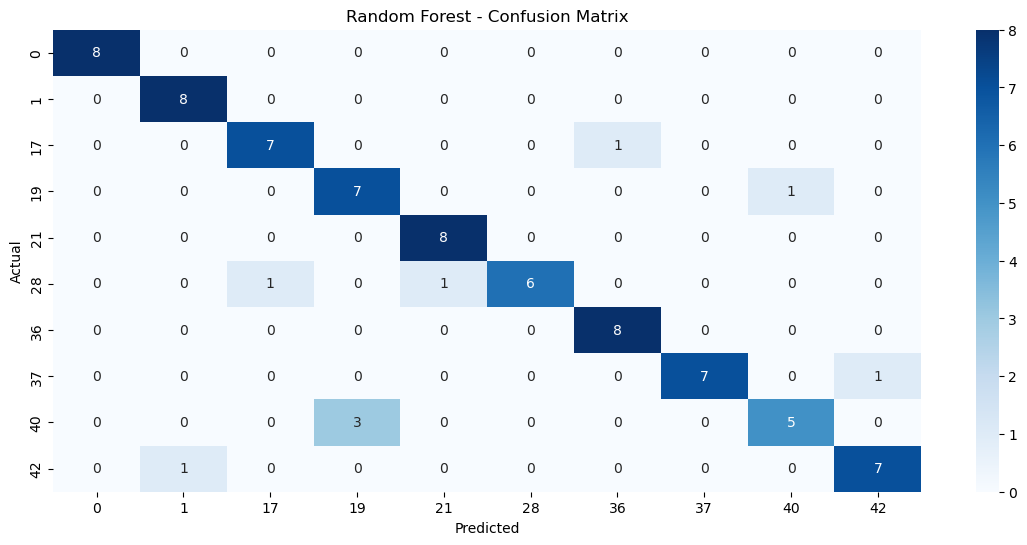

In [34]:
# Calculate AUC score for multi-class classification
test_auc_rf = roc_auc_score(y_test, y_prob_rf, multi_class='ovr')

# Calculate accuracy on the test set
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Calculate training accuracy
y_train_pred = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Display evaluation metrics
print("\nRandom Forest - AUC on the test set:", test_auc_rf)
print("\nRandom Forest - Accuracy on the test set:", accuracy_rf)
print("\nTraining Accuracy:", train_accuracy)
print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Visualize the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(14, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest - Confusion Matrix')
plt.show()

### **Random Forest Hyperparameter Tuning**  
Performs grid search with 5-fold cross-validation to find the best parameters for the Random Forest classifier.

In [35]:
# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],      # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],     # Maximum tree depth
    'min_samples_split': [2, 5, 10]      # Minimum samples required to split a node
}

# Grid search with 5-fold cross-validation using multi-class AUC as the metric
grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='roc_auc_ovr',
    n_jobs=-1,
    verbose=1
)

# Fit the model and display the best parameters
grid_search_rf.fit(X_train, y_train)
print("\nBest Parameters for Random Forest:", grid_search_rf.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits



Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


### **Training and Predicting with Random Forest**  
Train the Random Forest classifier using the best hyperparameters, make predictions on the test set, and compute class probabilities.

In [36]:
# Train Random Forest with the best parameters from grid search
rf = RandomForestClassifier(
    n_estimators=100,     # Number of trees in the forest
    max_depth=10,         # Maximum tree depth
    min_samples_split=10, # Minimum samples to split a node
    random_state=42       # Ensures reproducibility
)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf.predict(X_test)

# Compute predicted probabilities for AUC evaluation
y_prob_rf = rf.predict_proba(X_test)

### **Evaluate Random Forest Performance**  
Evaluate the performance of the Random Forest model using AUC, accuracy, and a classification report. Visualize the confusion matrix to understand prediction distribution.


Random Forest - AUC on the test set: 0.9928819444444444

Random Forest - Accuracy on the test set: 0.9125

Training Accuracy: 1.0

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.89      1.00      0.94         8
          17       0.75      0.75      0.75         8
          19       0.80      1.00      0.89         8
          21       1.00      1.00      1.00         8
          28       1.00      0.75      0.86         8
          36       0.89      1.00      0.94         8
          37       1.00      1.00      1.00         8
          40       1.00      0.75      0.86         8
          42       1.00      0.88      0.93         8

    accuracy                           0.91        80
   macro avg       0.92      0.91      0.91        80
weighted avg       0.92      0.91      0.91        80



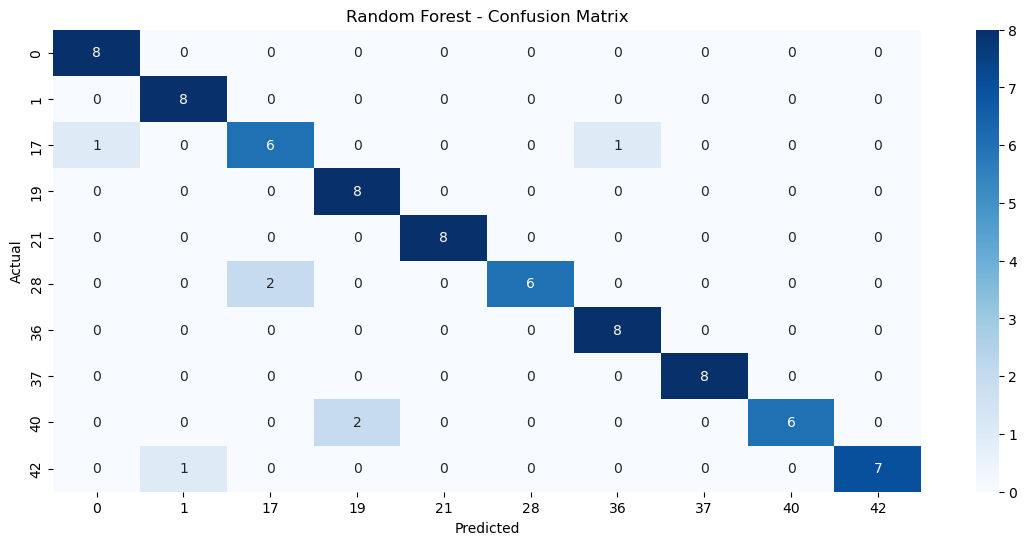

In [37]:
# Calculate AUC and accuracy on the test set
test_auc_rf = roc_auc_score(y_test, y_prob_rf, multi_class='ovr')  # One-vs-Rest AUC score
accuracy_rf = accuracy_score(y_test, y_pred_rf)  # Overall accuracy

# Display evaluation metrics
print("\nRandom Forest - AUC on the test set:", test_auc_rf)
print("\nRandom Forest - Accuracy on the test set:", accuracy_rf)

# Evaluate and print accuracy on the training set
y_train_pred = rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("\nTraining Accuracy:", train_accuracy)

# Display classification report
print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix visualization
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(14, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest - Confusion Matrix')
plt.show()

### **Test Feature Combinations with Random Forest**  
Test different combinations of features using Random Forest with Stratified K-Fold cross-validation. Evaluate performance based on accuracy, AUC, and overfitting thresholds.

In [38]:
if compute_features_comination_rf:
    # Evaluate feature combinations with Random Forest using specified parameters
    rf_results = test_feature_combinations(
        combinations_dict=feature_combinations,  # Dictionary of feature sets to combine
        y=y,  # Target labels
        model=RandomForestClassifier(),  # Random Forest classifier
        model_name="Random Forest",  # Model name for output display
        model_params={  # Default model hyperparameters
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 5,
            'random_state': 42
        },
        n_splits=5,  # Number of Stratified K-Folds for cross-validation
        normalize=False,  # Do not normalize features
        apply_pca=False,  # Disable PCA by default; can be enabled if needed
        n_pca_components=10,  # Number of PCA components if PCA is applied
        overfit_threshold=0.15,  # Threshold for detecting overfitting
        use_gridsearch=False,  # Disable GridSearch (set to True if needed)
        hyperparameter_grid={  # Hyperparameter grid (used only when GridSearch is enabled)
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        },
        top_k_results=5,  # Show top 5 combinations
        verbose=True  # Enable detailed output during testing
    )

### **Feature Selection and Train-Test Splitting**  
Select specific features for training the model. In this case, only spectral and pitch-related features are selected. Split the dataset into training and test sets using the selected features.

In [39]:
# Select spectral and pitch-related features for training
feature_selection = {
    'mfcc': False,              # Exclude MFCC features
    'delta_mfcc': False,        # Exclude delta MFCC
    'hist': False,              # Exclude histogram features
    'spectral_centroid': True,  # Include spectral centroid
    'spectral_contrast': True,  # Include spectral contrast
    'pitch_features': True,     # Include pitch-related features
    'zcr': False,               # Exclude zero-crossing rate
    'envelope': False,          # Exclude envelope features
    'hnr': False                # Exclude harmonic-to-noise ratio
}

# Load and split data based on the selected features
selected_features, X_train, X_test, y_train, y_test, selected_features_names = load_and_split_features(
    loaded_data, feature_selection
)

Combined feature shape: (400, 20)
Feature shapes and selection status:
Mfcc shape: (400, 13) - Status: ❌
Delta_mfcc shape: (400, 13) - Status: ❌
Hist shape: (400, 80) - Status: ❌
Spectral_centroid shape: (400, 2) - Status: ✅
Spectral_contrast shape: (400, 16) - Status: ✅
Pitch_features shape: (400, 2) - Status: ✅
Zcr shape: (400, 2) - Status: ❌
Envelope shape: (400, 5) - Status: ❌
Hnr shape: (400, 1) - Status: ❌

Combined features shape: (400, 20)


### **Random Forest Model Evaluation with K-Fold Cross-Validation**  
Evaluate the Random Forest classifier using 5-fold cross-validation. The classifier is configured with specific hyperparameters, and the evaluation checks for overfitting by comparing validation performance across folds.

In [40]:
# Perform K-Fold Cross-Validation for Random Forest classifier
rf_results = kfold_cross_validation(
    features=selected_features,             # Selected input features
    labels=y,                               # Corresponding class labels
    selected_features_names=selected_features_names,  # Feature names for reporting
    model=RandomForestClassifier(),         # Random Forest classifier
    model_params={                          # Random Forest hyperparameters
        'n_estimators': 100,                # Number of trees in the forest
        'max_depth': 10,                    # Maximum depth of each tree
        'min_samples_split': 5,             # Minimum samples required to split a node
        'random_state': 42                  # For reproducibility
    },
    n_splits=5,                             # Number of folds for cross-validation
    preprocess_params={                     # Preprocessing configuration
        'normalize': False,                 # Disable feature normalization
        'apply_pca': False,                 # Disable PCA for this evaluation
        'n_pca_components': 10              # Number of PCA components (if enabled)
    },
    overfit_threshold=0.15                  # Threshold to detect overfitting
)


Settings:
 - Selected Features: spectral_centroid, spectral_contrast, pitch_features
 - Model: RandomForestClassifier
 - Model Parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'random_state': 42}
 - Preprocessing: {'normalize': False, 'apply_pca': False, 'n_pca_components': 10}


[Fold 1]
   - Train Accuracy: 0.9969, Test Accuracy: 0.7500
   - AUC: 0.9835
   - Precision: 0.7818, Recall: 0.7500, F1-score: 0.7546

[Fold 2]
   - Train Accuracy: 1.0000, Test Accuracy: 0.8375
   - AUC: 0.9917
   - Precision: 0.8524, Recall: 0.8375, F1-score: 0.8366

[Fold 3]
   - Train Accuracy: 1.0000, Test Accuracy: 0.7250
   - AUC: 0.9762
   - Precision: 0.7371, Recall: 0.7250, F1-score: 0.7175

[Fold 4]
   - Train Accuracy: 1.0000, Test Accuracy: 0.7750
   - AUC: 0.9667
   - Precision: 0.7998, Recall: 0.7750, F1-score: 0.7744

[Fold 5]
   - Train Accuracy: 1.0000, Test Accuracy: 0.8125
   - AUC: 0.9714
   - Precision: 0.8330, Recall: 0.8125, F1-score: 0.8162

K-Fold Summary:
 

### **Random Forest Evaluation Across Feature Groups**  
Evaluate the Random Forest classifier using 5-fold cross-validation with the following settings:  
- **n_estimators:** 100  
- **max_depth:** 10  
- **min_samples_split:** 5  
- **Preprocessing:** No normalization, PCA disabled  
- **Overfitting Detection Threshold:** 0.15  
- **Evaluation:** Assess performance metrics across different feature groups, including classification accuracy and overfitting status.

In [41]:
# Random Forest classifier and K-Fold cross-validation settings
rf_params = {
    'n_estimators': 100,               # Number of trees in the forest
    'max_depth': 10,                   # Maximum depth of the trees
    'min_samples_split': 5,            # Minimum samples required to split a node
    'random_state': 42                 # For reproducibility
}

kfold_params_rf = {
    'n_splits': 5,                     # Number of K-Folds for cross-validation
    'preprocess_params': {             # Preprocessing settings
        'normalize': False,            # Disable feature normalization
        'apply_pca': False,            # Disable PCA for this evaluation
        'n_pca_components': 0.9        # Number of PCA components if enabled
    },
    'overfit_threshold': 0.15          # Threshold to identify overfitting
}

# Evaluate Random Forest performance across multiple feature groups
rf_results_df = run_classifier_on_feature_groups(
    feature_groups_selection=feature_groups_selection,  # Different feature combinations
    loaded_data=loaded_data,                            # Loaded feature data
    y=y,                                                # Class labels
    classifier=RandomForestClassifier(),                # Random Forest classifier
    classifier_params=rf_params,                        # Classifier parameters
    kfold_params=kfold_params_rf,                       # K-Fold cross-validation configuration
    plot_boxplots=False,                                # Disable boxplot visualization
    plot_confusion_matrix=False,                        # Disable confusion matrix visualization
    display_iteration_details=False,                    # Suppress detailed iteration outputs
    display_classification_report=True                  # Display classification report
)


🔄 Running RandomForestClassifier on Feature Group: group_1_temporal
Selected features in this group: ['delta_mfcc', 'zcr', 'envelope']
Combined feature shape: (400, 20)
Feature shapes and selection status:
Mfcc shape: (400, 13) - Status: ❌
Delta_mfcc shape: (400, 13) - Status: ✅
Hist shape: (400, 80) - Status: ❌
Spectral_centroid shape: (400, 2) - Status: ❌
Spectral_contrast shape: (400, 16) - Status: ❌
Pitch_features shape: (400, 2) - Status: ❌
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ❌

Combined features shape: (400, 20)
Combined features shape: (400, 20)

Settings:
 - Selected Features: delta_mfcc, zcr, envelope
 - Model: RandomForestClassifier
 - Model Parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'random_state': 42}
 - Preprocessing: {'normalize': False, 'apply_pca': False, 'n_pca_components': 0.9}


K-Fold Summary:
 - Average Train Accuracy: 1.0000
 - Average Test Accuracy: 0.6350
 - Average A

---
---

## **Section 4: K-Nearest Neighbors (KNN) Classifier**  
This section focuses on evaluating the KNN classifier using different feature groups. The classifier is optimized using K-Fold cross-validation, and performance metrics such as accuracy and overfitting status are analyzed for each feature combination.

### **KNN Feature Loading and Preprocessing**  
- Load saved audio features from the NPZ file.  
- Select features based on configuration and split into train/test sets.  
- Apply Z-score normalization to both datasets.  
- PCA is disabled for this step (but can be enabled if needed).

In [42]:
# Load saved features from NPZ file
loaded_data = np.load("features/extracted_features_multiple_test.npz")

# Define features to be included in the training process
feature_selection = {
    'mfcc': True,
    'delta_mfcc': True,
    'hist': True,
    'spectral_centroid': True,
    'spectral_contrast': True,
    'pitch_features': True,
    'zcr': True,
    'envelope': True,
    'hnr': True
}

# Select and split features into train and test sets
selected_features, X_train, X_test, y_train, y_test, selected_features_names = load_and_split_features(
    loaded_data, feature_selection
)

# Apply normalization and (optional) PCA preprocessing
X_train, X_test = preprocess_features(
    X_train, X_test, 
    normalize=True,          # Apply Z-score normalization
    apply_pca=False,         # Disable PCA for this configuration
    n_pca_components=0.9,    # Retain 90% variance if PCA is enabled
    verbose=True             # Print preprocessing details
)

Combined feature shape: (400, 134)
Feature shapes and selection status:
Mfcc shape: (400, 13) - Status: ✅
Delta_mfcc shape: (400, 13) - Status: ✅
Hist shape: (400, 80) - Status: ✅
Spectral_centroid shape: (400, 2) - Status: ✅
Spectral_contrast shape: (400, 16) - Status: ✅
Pitch_features shape: (400, 2) - Status: ✅
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 134)
✅ Normalization applied.
❌ PCA skipped.


### **KNN Classification and Evaluation**  
Train KNN classifier with `k=3`, evaluate using accuracy, AUC, and visualize the confusion matrix.  


KNN Test Accuracy: 0.7000
KNN Test AUC: 0.9062

KNN Training Accuracy: 0.8719

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.78      0.88      0.82         8
          17       0.67      0.75      0.71         8
          19       0.67      1.00      0.80         8
          21       0.62      1.00      0.76         8
          28       0.45      0.62      0.53         8
          36       1.00      0.75      0.86         8
          37       1.00      0.50      0.67         8
          40       1.00      0.38      0.55         8
          42       0.83      0.62      0.71         8

    accuracy                           0.70        80
   macro avg       0.76      0.70      0.69        80
weighted avg       0.76      0.70      0.69        80



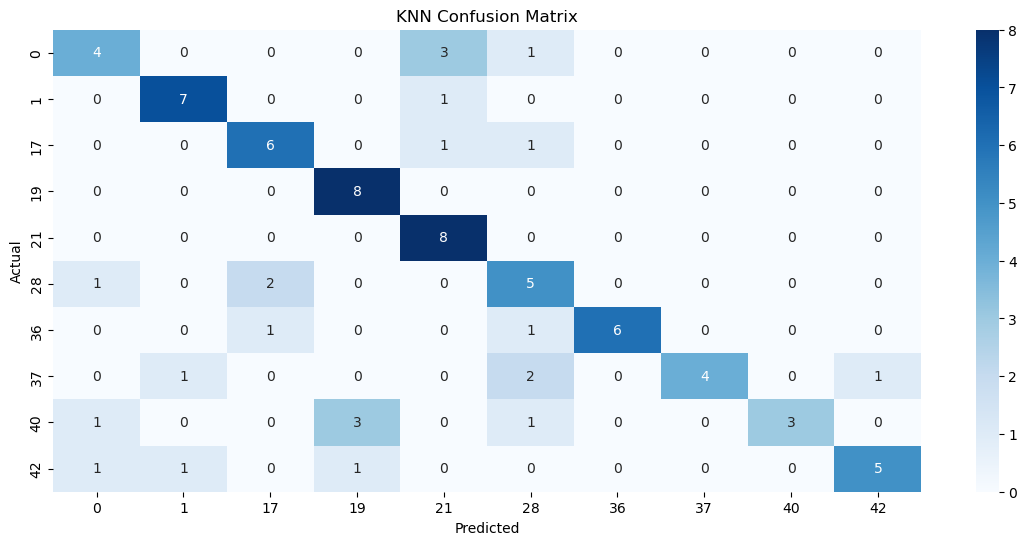

In [43]:
# Initialize and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Make predictions on train and test sets
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)
y_train_pred = knn.predict(X_train)

# Evaluate accuracy and AUC
test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
train_accuracy = accuracy_score(y_train, y_train_pred)

# Display results
print(f"\nKNN Test Accuracy: {test_accuracy:.4f}")
print(f"KNN Test AUC: {test_auc:.4f}")
print(f"\nKNN Training Accuracy: {train_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(14, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix')
plt.show()

### **KNN Hyperparameter Tuning**  
Perform grid search to find the best combination of `n_neighbors`, `weights`, and distance `metrics` using cross-validation.

In [44]:
# Define the hyperparameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],       # Number of neighbors to consider
    'weights': ['uniform', 'distance'], # Weight function used in prediction
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}

# Perform grid search to find the best hyperparameters
grid_search_knn, best_params_knn, best_score_knn = grid_search_hyperparameter_tuning(
    model=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    X_train=X_train,
    y_train=y_train
)

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best roc_auc_ovr Score: 0.9609


### **KNN Feature Combination Testing**  
Evaluate different combinations of selected features using KNN with predefined parameters through cross-validation.

In [45]:
if compute_features_comination_knn:
    # Evaluate feature combinations using KNN classifier
    knn_results = test_feature_combinations(
        combinations_dict=feature_combinations,  # Feature combinations to evaluate
        y=y,  # Target labels
        model=KNeighborsClassifier(),  # KNN model
        model_name="KNN",  # For display purposes
        model_params={  # KNN configuration
            'n_neighbors': 7,
            'weights': 'uniform',
            'metric': 'euclidean'
        },
        n_splits=5,  # Number of folds for cross-validation
        normalize=True,  # Normalize features
        apply_pca=False,  # No dimensionality reduction
        n_pca_components=10,  # Placeholder if PCA is enabled
        overfit_threshold=0.1,  # Overfitting detection threshold
        use_gridsearch=False,  # Skip grid search
        top_k_results=5,  # Display the top 5 combinations
        verbose=True  # Print details during evaluation
    )

In [46]:
feature_selection = {
    'mfcc': True,
    'delta_mfcc': True,
    'hist': False,
    'spectral_centroid': True,
    'spectral_contrast': True,
    'pitch_features': True,
    'zcr': False,
    'envelope': True,
    'hnr': True
}

selected_features, X_train, X_test, y_train, y_test, selected_features_names = load_and_split_features(
    loaded_data, feature_selection
)

X_train, X_test = preprocess_features(
    X_train, X_test, normalize=True, apply_pca=False, n_pca_components=0.9
)

Combined feature shape: (400, 52)
Feature shapes and selection status:
Mfcc shape: (400, 13) - Status: ✅
Delta_mfcc shape: (400, 13) - Status: ✅
Hist shape: (400, 80) - Status: ❌
Spectral_centroid shape: (400, 2) - Status: ✅
Spectral_contrast shape: (400, 16) - Status: ✅
Pitch_features shape: (400, 2) - Status: ✅
Zcr shape: (400, 2) - Status: ❌
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 52)
✅ Normalization applied.
❌ PCA skipped.


### **KNN Classifier Evaluation**  
Train the KNN classifier using optimal parameters, make predictions on the test set, and evaluate the model's accuracy and AUC. Display the classification report and confusion matrix.


KNN Test Accuracy: 0.7375
KNN Test AUC: 0.9617

KNN Training Accuracy: 0.8094

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.73      1.00      0.84         8
          17       0.60      0.38      0.46         8
          19       0.73      1.00      0.84         8
          21       0.57      1.00      0.73         8
          28       0.83      0.62      0.71         8
          36       0.78      0.88      0.82         8
          37       1.00      0.50      0.67         8
          40       0.71      0.62      0.67         8
          42       1.00      0.62      0.77         8

    accuracy                           0.74        80
   macro avg       0.77      0.74      0.73        80
weighted avg       0.77      0.74      0.73        80



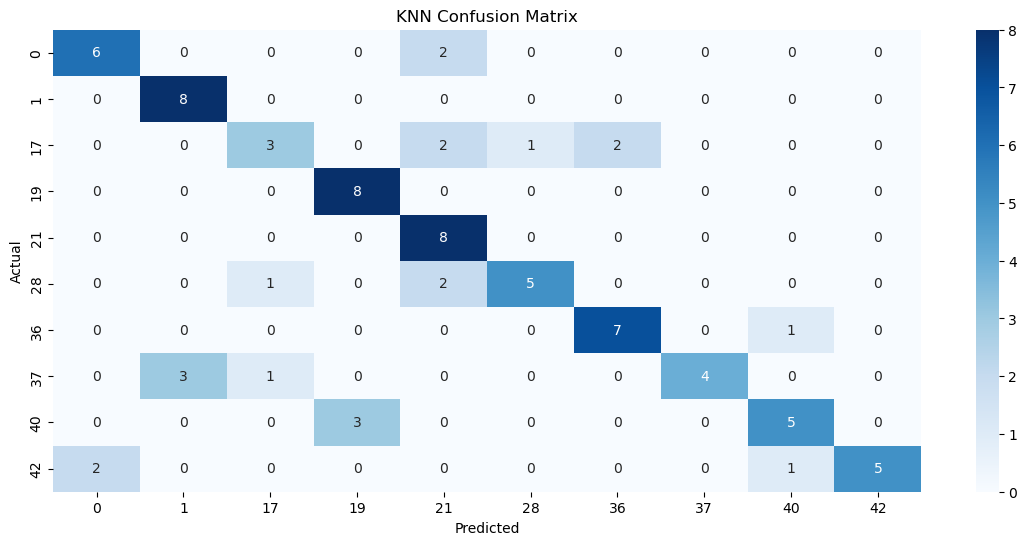

In [47]:
# Initialize and train KNN classifier
knn = KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='euclidean')
knn.fit(X_train, y_train)

# Predictions on test and train sets
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)
y_train_pred = knn.predict(X_train)

# Evaluate performance
test_accuracy = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
train_accuracy = accuracy_score(y_train, y_train_pred)

# Display results
print(f"\nKNN Test Accuracy: {test_accuracy:.4f}")
print(f"KNN Test AUC: {test_auc:.4f}")
print(f"\nKNN Training Accuracy: {train_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(14, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN Confusion Matrix')
plt.show()

### **Feature Selection and Splitting**
Select specific audio features based on their relevance and split the dataset into training and testing sets for further analysis.

In [48]:
# Define features to include for model training
feature_selection = {
    'mfcc': True,               # Include MFCC features
    'delta_mfcc': True,         # Include delta MFCC
    'hist': False,              # Exclude histogram features
    'spectral_centroid': True,  # Include spectral centroid
    'spectral_contrast': True,  # Include spectral contrast
    'pitch_features': True,     # Include pitch-related features
    'zcr': False,               # Exclude zero-crossing rate
    'envelope': True,           # Include envelope features
    'hnr': True                 # Include Harmonics-to-Noise Ratio (HNR)
}

# Load and split the features into train and test sets
selected_features, X_train, X_test, y_train, y_test, selected_features_names = load_and_split_features(
    loaded_data, feature_selection
)

Combined feature shape: (400, 52)
Feature shapes and selection status:
Mfcc shape: (400, 13) - Status: ✅
Delta_mfcc shape: (400, 13) - Status: ✅
Hist shape: (400, 80) - Status: ❌
Spectral_centroid shape: (400, 2) - Status: ✅
Spectral_contrast shape: (400, 16) - Status: ✅
Pitch_features shape: (400, 2) - Status: ✅
Zcr shape: (400, 2) - Status: ❌
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ✅

Combined features shape: (400, 52)


### **KNN Cross-Validation with Overfitting Detection**  
Conduct 5-fold cross-validation on the KNN classifier with the following configuration:  
- **n_neighbors:** 7  
- **weights:** uniform  
- **metric:** Euclidean distance  
- **Preprocessing:** Z-score normalization (PCA disabled)  
- **Overfitting Detection Threshold:** 0.15

In [49]:
knn_results = kfold_cross_validation(
    features=selected_features,  # Selected input features
    labels=y,  # Target labels
    selected_features_names=selected_features_names,  # Names of the selected features
    model=KNeighborsClassifier(),  # Initialize the KNN model
    model_params={  # Set KNN parameters
        'n_neighbors': 7,  # Number of neighbors
        'weights': 'uniform',  # Uniform weights for neighbors
        'metric': 'euclidean'  # Euclidean distance metric
    },
    n_splits=5,  # 5-fold cross-validation
    preprocess_params={  # Preprocessing options
        'normalize': True,  # Apply Z-score normalization
        'apply_pca': False,  # Disable PCA
        'n_pca_components': 0.8  # Placeholder if PCA is enabled
    },
    overfit_threshold=0.15  # Overfitting detection threshold
)


Settings:
 - Selected Features: mfcc, delta_mfcc, spectral_centroid, spectral_contrast, pitch_features, envelope, hnr
 - Model: KNeighborsClassifier
 - Model Parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean'}
 - Preprocessing: {'normalize': True, 'apply_pca': False, 'n_pca_components': 0.8}


[Fold 1]
   - Train Accuracy: 0.8156, Test Accuracy: 0.7875
   - AUC: 0.9619
   - Precision: 0.8345, Recall: 0.7875, F1-score: 0.7872

[Fold 2]
   - Train Accuracy: 0.8156, Test Accuracy: 0.8375
   - AUC: 0.9676
   - Precision: 0.8564, Recall: 0.8375, F1-score: 0.8284

[Fold 3]
   - Train Accuracy: 0.8000, Test Accuracy: 0.7000
   - AUC: 0.9733
   - Precision: 0.7627, Recall: 0.7000, F1-score: 0.6905

[Fold 4]
   - Train Accuracy: 0.8406, Test Accuracy: 0.7125
   - AUC: 0.9476
   - Precision: 0.7505, Recall: 0.7125, F1-score: 0.6872

[Fold 5]
   - Train Accuracy: 0.8063, Test Accuracy: 0.7750
   - AUC: 0.9548
   - Precision: 0.8263, Recall: 0.7750, F1-score: 0.7671

K-Fol

### **KNN Classifier Evaluation Across Feature Groups**  
Evaluate KNN classifier performance using 5-fold cross-validation with the following settings:  
- **n_neighbors:** 7  
- **weights:** uniform  
- **metric:** Euclidean distance  
- **Preprocessing:** Z-score normalization, PCA disabled  
- **Overfitting Detection Threshold:** 0.15  
- **Evaluation:** Assess performance across multiple feature groups, including accuracy and overfitting status.

In [50]:
knn_params = {
    'n_neighbors': 7,
    'weights': 'uniform',
    'metric': 'euclidean'
}

kfold_params_knn = {
    'n_splits': 5,
    'preprocess_params': {'normalize': True, 'apply_pca': False, 'n_pca_components': 0.8},
    'overfit_threshold': 0.15
}

knn_results_df = run_classifier_on_feature_groups(
    feature_groups_selection=feature_groups_selection,
    loaded_data=loaded_data,
    y=y,
    classifier=KNeighborsClassifier(),
    classifier_params=knn_params,
    kfold_params=kfold_params_knn,
    plot_boxplots=False,
    plot_confusion_matrix=False,
    display_iteration_details=False,
    display_classification_report=True
)


🔄 Running KNeighborsClassifier on Feature Group: group_1_temporal
Selected features in this group: ['delta_mfcc', 'zcr', 'envelope']
Combined feature shape: (400, 20)
Feature shapes and selection status:
Mfcc shape: (400, 13) - Status: ❌
Delta_mfcc shape: (400, 13) - Status: ✅
Hist shape: (400, 80) - Status: ❌
Spectral_centroid shape: (400, 2) - Status: ❌
Spectral_contrast shape: (400, 16) - Status: ❌
Pitch_features shape: (400, 2) - Status: ❌
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ❌

Combined features shape: (400, 20)
Combined features shape: (400, 20)

Settings:
 - Selected Features: delta_mfcc, zcr, envelope
 - Model: KNeighborsClassifier
 - Model Parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean'}
 - Preprocessing: {'normalize': True, 'apply_pca': False, 'n_pca_components': 0.8}


K-Fold Summary:
 - Average Train Accuracy: 0.5919
 - Average Test Accuracy: 0.4375
 - Average AUC: 0.8412
 - Average TP

---
---

## **Section 5: K-Means Clustering (Unsupervised Learning)**  
This section evaluates the K-Means algorithm to cluster audio data using selected feature groups:  
- **Feature Selection:** Choose key features to analyze and cluster the data.  
- **K-Means Initialization:** Random state and `k` determined by optimization.  
- **Evaluation:** Silhouette score, Adjusted Rand Index (ARI), and t-SNE visualization to analyze the clustering quality.  
- **Cluster Labeling:** Majority voting is used to map clusters to their respective classes, and a confusion matrix is generated.

### **K-Means Clustering on Multiple Feature Groups**
This section evaluates K-Means clustering performance across various feature combinations:  
- **Initialization:** Using KMeans++ with 30 restarts (`n_init=30`) for stability.  
- **PCA Options:** Compares clustering results with and without dimensionality reduction.  
- **Evaluation:** Silhouette score and Adjusted Rand Index (ARI) used as metrics.  
- **Normalization:** Z-score normalization is applied to ensure feature scaling.

In [51]:
results_df = evaluate_kmeans_feature_groups(
    feature_groups_selection=feature_groups_selection,
    loaded_data=loaded_data,
    k=10,
    use_kmeans_pp=True,
    n_init=30,
    apply_pca_options=[True, False],
    n_pca_components=0.95,
    normalize=True,
    verbose=True
)


🔄 Testing Feature Group: group_1_temporal with PCA=Yes and Normalize=Yes
Combined feature shape: (400, 20)
Feature shapes and selection status:
Mfcc shape: (400, 13) - Status: ❌
Delta_mfcc shape: (400, 13) - Status: ✅
Hist shape: (400, 80) - Status: ❌
Spectral_centroid shape: (400, 2) - Status: ❌
Spectral_contrast shape: (400, 16) - Status: ❌
Pitch_features shape: (400, 2) - Status: ❌
Zcr shape: (400, 2) - Status: ✅
Envelope shape: (400, 5) - Status: ✅
Hnr shape: (400, 1) - Status: ❌

Combined features shape: (400, 20)

📊 Cluster Statistics:
Cluster 0 (Majority Class: 17) → 50.00% of samples belong to class 17
Cluster 1 (Majority Class: 1) → 26.92% of samples belong to class 1
Cluster 2 (Majority Class: 21) → 27.38% of samples belong to class 21
Cluster 3 (Majority Class: 42) → 75.00% of samples belong to class 42
Cluster 4 (Majority Class: 36) → 51.43% of samples belong to class 36
Cluster 5 (Majority Class: 17) → 35.71% of samples belong to class 17
Cluster 6 (Majority Class: 42) → 

### **Feature Selection and Preprocessing for K-Means**
- **Feature Selection:** Uses a pre-defined group of general features (`group_6_general_2`).  
- **Data Combination:** Combines training and test sets to create a full dataset for unsupervised learning.  
- **Normalization & PCA:** Applies Z-score normalization and reduces dimensionality to retain 95% variance using PCA.

In [52]:
feature_selection = {
    'mfcc': True,
    'delta_mfcc': True,
    'hist': False,
    'spectral_centroid': True,
    'spectral_contrast': True,
    'pitch_features': True,
    'zcr': True,
    'envelope': True,
    'hnr': True
}

# Select and load features
feature_selection = feature_groups_selection['group_6_general_2']
selected_features, X_train, X_test, y_train, y_test, selected_features_names = load_and_split_features(loaded_data, feature_selection)

# Combine and preprocess
X_full = np.vstack([X_train, X_test])
y_full = np.hstack([y_train, y_test])
X_full, _ = preprocess_features(X_full, X_full, normalize=True, apply_pca=True, n_pca_components=0.95)

Combined feature shape: (400, 33)
Feature shapes and selection status:
Mfcc shape: (400, 13) - Status: ✅
Delta_mfcc shape: (400, 13) - Status: ❌
Hist shape: (400, 80) - Status: ❌
Spectral_centroid shape: (400, 2) - Status: ✅
Spectral_contrast shape: (400, 16) - Status: ✅
Pitch_features shape: (400, 2) - Status: ✅
Zcr shape: (400, 2) - Status: ❌
Envelope shape: (400, 5) - Status: ❌
Hnr shape: (400, 1) - Status: ❌

Combined features shape: (400, 33)
✅ Normalization applied.
✅ PCA applied. Selected 22 components (explained variance: 0.96).
Reduced feature shape after PCA: 22


## K-Means Clustering Evaluation

This script determines the optimal number of clusters (`k`) using:

- **Elbow Method** (Inertia) to find the best `k`.
- **Silhouette Score** to assess clustering quality.

It applies K-Means for `k = 2 to 19`, computes both metrics, and visualizes the results.


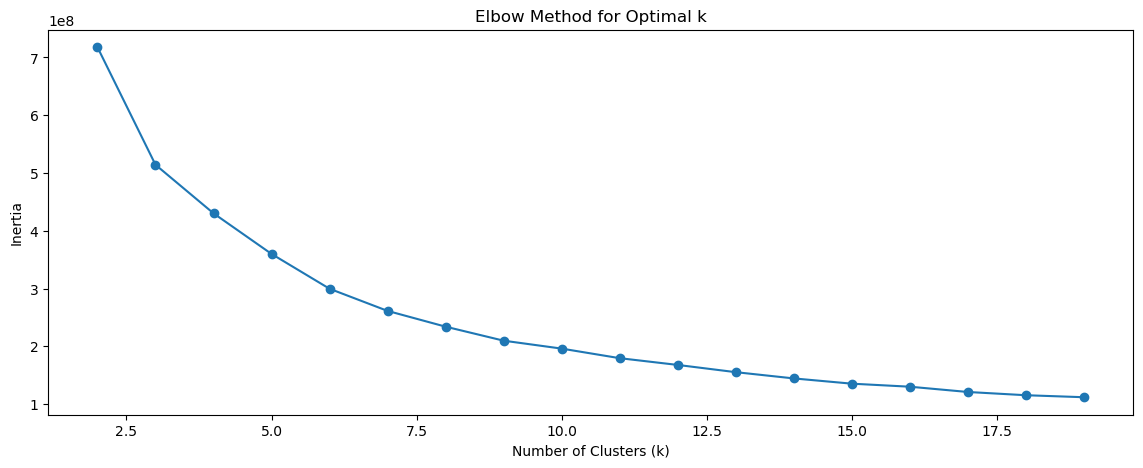

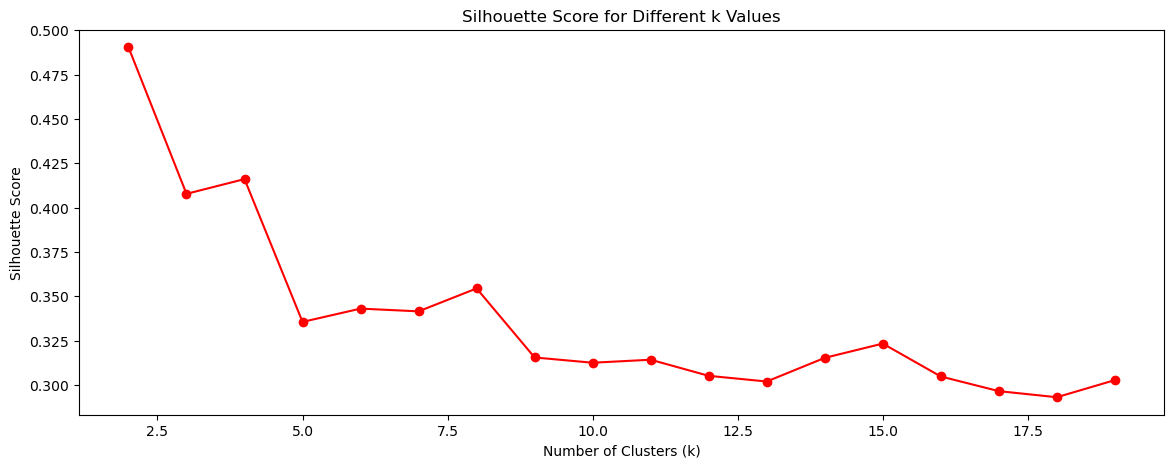

In [53]:
# Lists to store inertia and silhouette scores for different k values
inertia = []
sil_scores = [] 

# Range of cluster numbers to evaluate
K_range = range(2, 20)

for k in K_range:
    # Initialize and fit K-Means with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X_train)
    
    # Store inertia (sum of squared distances to cluster centers)
    inertia.append(kmeans.inertia_)
    
    # Store silhouette score (measures clustering quality)
    sil_scores.append(silhouette_score(X_train, labels))  

# Plot inertia to determine the elbow point
plt.figure(figsize=(14,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

# Plot silhouette scores to evaluate clustering quality
plt.figure(figsize=(14,5))
plt.plot(K_range, sil_scores, marker='o', label='Silhouette Score', color='red')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different k Values")
plt.show()


###  KMeans Clustering and Performance Evaluation
- Perform KMeans++ clustering
- Evaluate using Silhouette and ARI scores
- Visualize clusters with t-SNE
- Generate confusion matrix

Silhouette Score: 0.1412
ARI Score: 0.4069


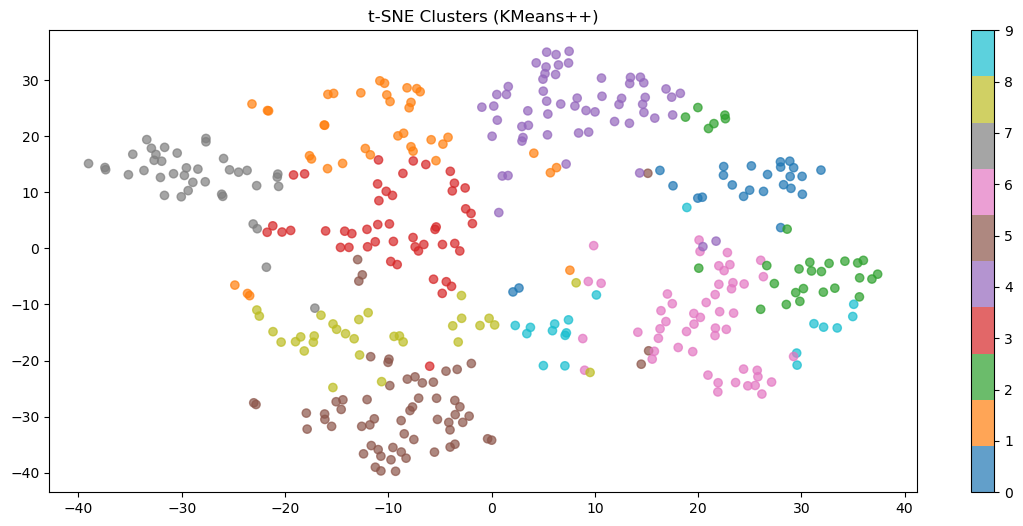

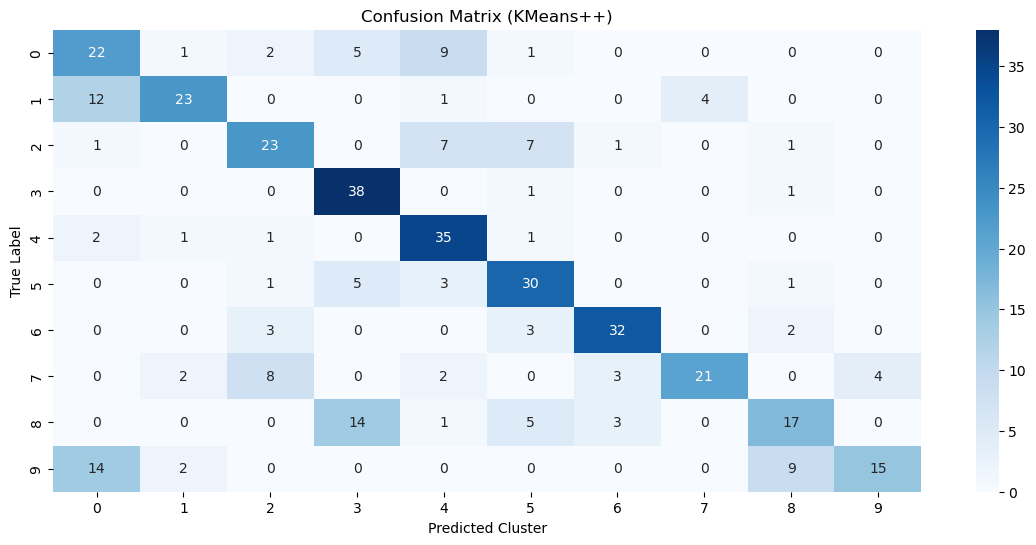

In [54]:
# KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42, n_init=30, init='k-means++')
cluster_labels = kmeans.fit_predict(X_full)

# Silhouette and ARI scores
silhouette = silhouette_score(X_full, cluster_labels)
ari_score = adjusted_rand_score(y_full, cluster_labels)
print(f"Silhouette Score: {silhouette:.4f}")
print(f"ARI Score: {ari_score:.4f}")

# t-SNE visualization
X_embedded = TSNE(n_components=2, perplexity=15, random_state=42).fit_transform(X_full)
plt.figure(figsize=(14, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.colorbar()
plt.title("t-SNE Clusters (KMeans++)")
plt.show()

# Majority class assignment
def assign_labels_majority(y_true, cluster_labels):
    assigned_labels = np.zeros_like(cluster_labels)
    for cluster in np.unique(cluster_labels):
        mask = (cluster_labels == cluster)
        true_labels = y_true[mask]  
        if len(true_labels) > 0:
            assigned_labels[mask] = mode(true_labels, keepdims=True).mode[0]
    return assigned_labels

y_pred = assign_labels_majority(y_full, cluster_labels)

# Confusion matrix
cm = confusion_matrix(y_full, y_pred)
plt.figure(figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Label')
plt.title('Confusion Matrix (KMeans++)')
plt.show()

###  Cluster Size Distribution
- Display the number of samples in each cluster

In [55]:
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))

print("\n🔍 Cluster Size Distribution:")
for cluster, count in sorted(cluster_distribution.items()):
    print(f"Cluster {cluster}: {count} samples")


🔍 Cluster Size Distribution:
Cluster 0: 25 samples
Cluster 1: 38 samples
Cluster 2: 29 samples
Cluster 3: 48 samples
Cluster 4: 58 samples
Cluster 5: 62 samples
Cluster 6: 51 samples
Cluster 7: 39 samples
Cluster 8: 31 samples
Cluster 9: 19 samples


###  Majority Class in Each Cluster
- Determine which class dominates each cluster

In [56]:
for cluster in np.unique(cluster_labels):
    assigned_class = mode(y_full[cluster_labels == cluster], keepdims=True).mode[0]
    print(f"Cluster {cluster} is mostly class {assigned_class}")

Cluster 0 is mostly class 37
Cluster 1 is mostly class 17
Cluster 2 is mostly class 1
Cluster 3 is mostly class 28
Cluster 4 is mostly class 21
Cluster 5 is mostly class 19
Cluster 6 is mostly class 0
Cluster 7 is mostly class 36
Cluster 8 is mostly class 40
Cluster 9 is mostly class 42


###  Stacked Bar Chart of Class Distribution
- Plot the number of samples from each class within clusters

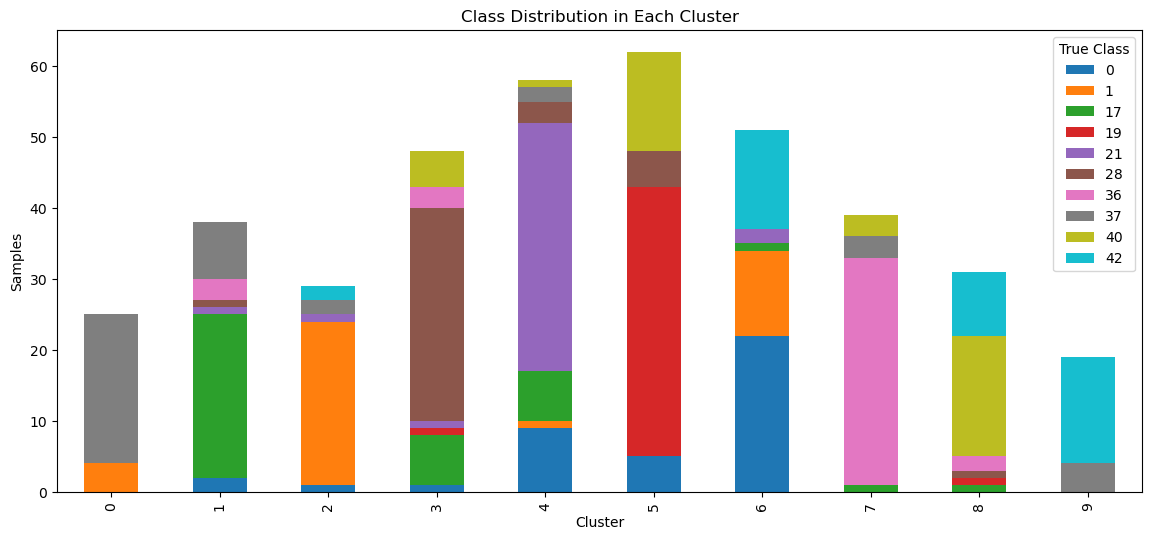

In [57]:
cluster_class_df = pd.DataFrame({'Cluster': cluster_labels, 'True Class': y_full})
cluster_counts = cluster_class_df.groupby(['Cluster', 'True Class']).size().unstack(fill_value=0)

cluster_counts.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='tab10')
plt.xlabel("Cluster")
plt.ylabel("Samples")
plt.title("Class Distribution in Each Cluster")
plt.legend(title="True Class")
plt.show()


###  Accuracy, Purity, and Majority Class Analysis
- Calculate majority class percentage, weighted accuracy, and purity score

In [58]:
percentage_majority_class = {}
weighted_accuracy_sum = 0
purity_numerator = 0
total_samples = len(y_full)

for cluster in np.unique(cluster_labels):
    assigned_class = mode(y_full[cluster_labels == cluster], keepdims=True).mode[0]
    total_in_cluster = cluster_distribution[cluster]
    majority_count = np.sum((cluster_labels == cluster) & (y_full == assigned_class))
    percentage = (majority_count / total_in_cluster) * 100
    percentage_majority_class[cluster] = percentage
    weighted_accuracy_sum += (majority_count / total_samples)
    purity_numerator += majority_count

    print(f"Cluster {cluster} (Majority: {assigned_class}) → {percentage:.2f}% in class {assigned_class}")

mean_majority_percentage = np.mean(list(percentage_majority_class.values()))
purity_score = purity_numerator / total_samples

print(f"\nMean Majority Percentage: {mean_majority_percentage:.2f}%")
print(f"Weighted Accuracy: {weighted_accuracy_sum:.4f}")
print(f"Purity Score: {purity_score:.4f}")

Cluster 0 (Majority: 37) → 84.00% in class 37
Cluster 1 (Majority: 17) → 60.53% in class 17
Cluster 2 (Majority: 1) → 79.31% in class 1
Cluster 3 (Majority: 28) → 62.50% in class 28
Cluster 4 (Majority: 21) → 60.34% in class 21
Cluster 5 (Majority: 19) → 61.29% in class 19
Cluster 6 (Majority: 0) → 43.14% in class 0
Cluster 7 (Majority: 36) → 82.05% in class 36
Cluster 8 (Majority: 40) → 54.84% in class 40
Cluster 9 (Majority: 42) → 78.95% in class 42

Mean Majority Percentage: 66.69%
Weighted Accuracy: 0.6400
Purity Score: 0.6400


###  Confusion Matrix and Class Distribution (%)
- Plot confusion matrix as a heatmap
- Visualize class distribution as a stacked bar chart

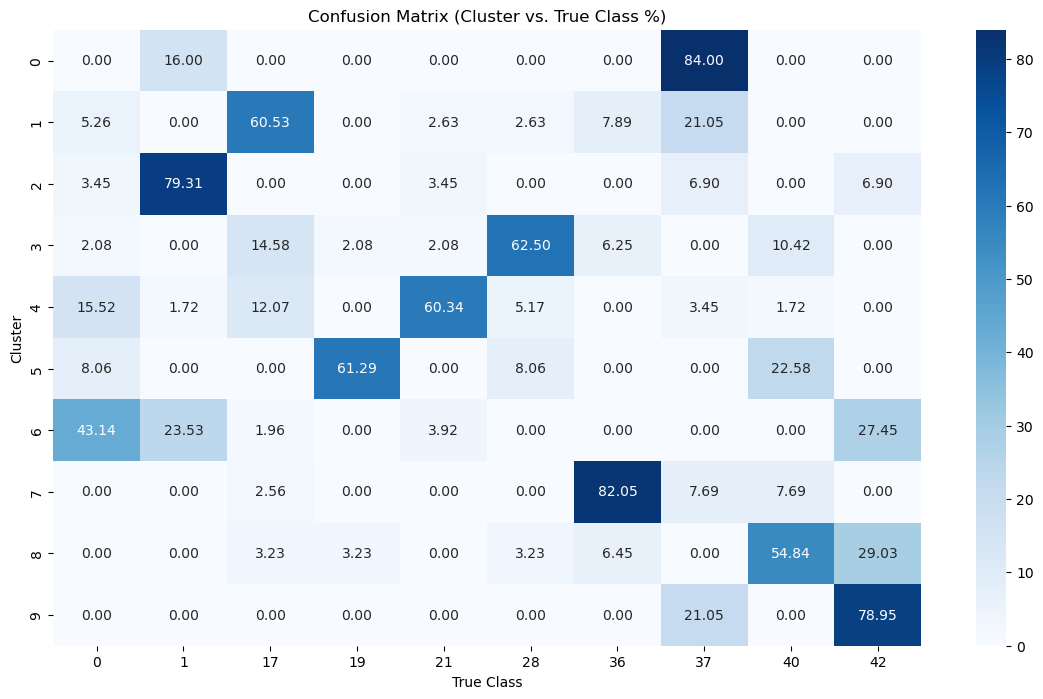

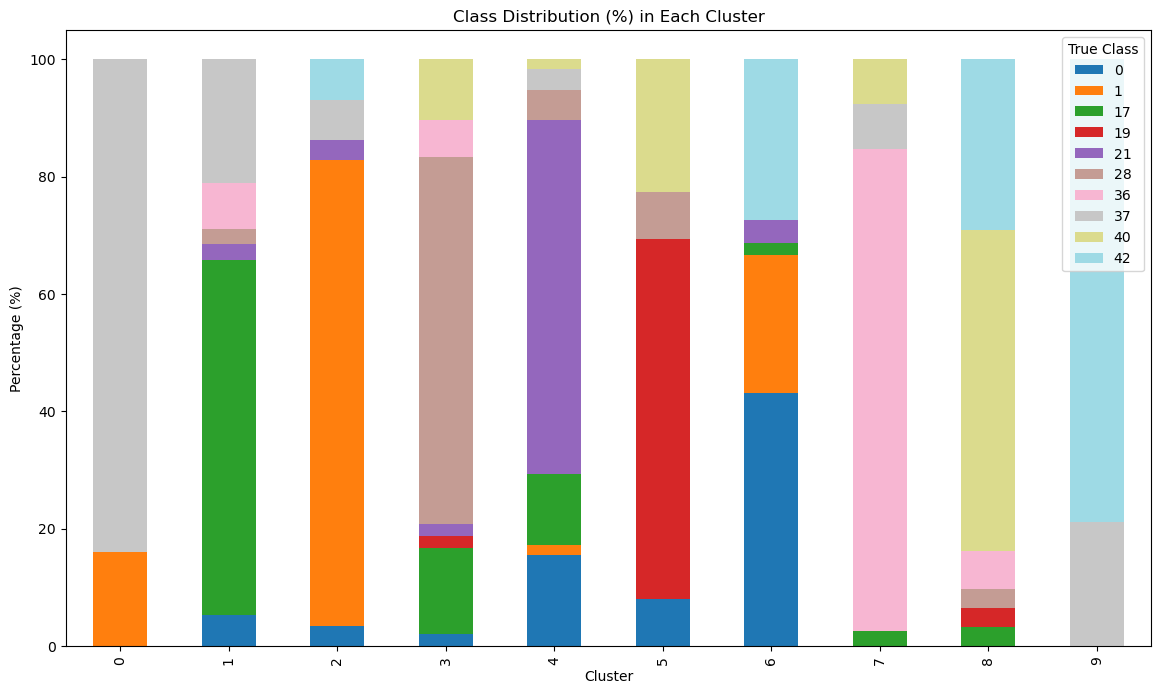

In [59]:
# Cluster-class distribution
conf_matrix = pd.crosstab(cluster_labels, y_full, rownames=['Cluster'], colnames=['True Class'])

# Normalize for percentage view
conf_matrix_percent = conf_matrix.div(conf_matrix.sum(axis=1), axis=0) * 100

# Heatmap visualization
plt.figure(figsize=(14, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap='Blues', cbar=True)
plt.title("Confusion Matrix (Cluster vs. True Class %)")
plt.xlabel("True Class")
plt.ylabel("Cluster")
plt.show()

# Stacked bar chart
conf_matrix_percent.plot(kind='bar', stacked=True, colormap='tab20', figsize=(14, 8))
plt.title("Class Distribution (%) in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Percentage (%)")
plt.legend(title="True Class")
plt.show()

# Model Performance Comparison - Visualizations

### 1. `plot_model_performance_comparison(knn_results, svm_results, rf_results)`
- **Purpose:** Bar and line plot comparing Test Accuracy, TPR, FPR, and AUC across KNN, SVM, and Random Forest models.
- **Interpretation:** Quickly assess each model's performance and identify potential overfitting or weaknesses.

### 2. `plot_coverage_radar(knn_results, svm_results, rf_results)`
- **Purpose:** Radar plot visualizing Train Accuracy, Test Accuracy, AUC, TPR, and FPR for all models.
- **Interpretation:** Holistic view of performance across multiple metrics, highlighting each model's strengths and weaknesses.

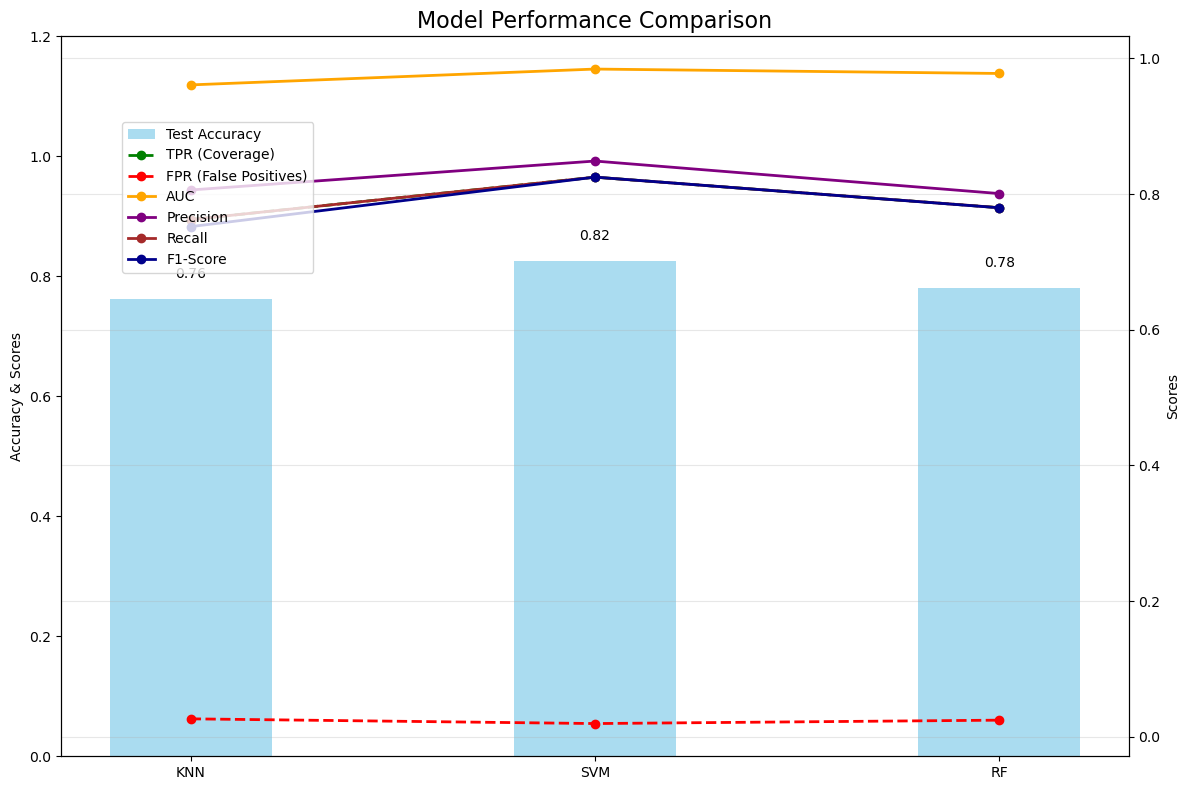

In [60]:
# Call the updated model performance comparison plot
plot_model_performance_comparison(knn_results, svm_results, rf_results)

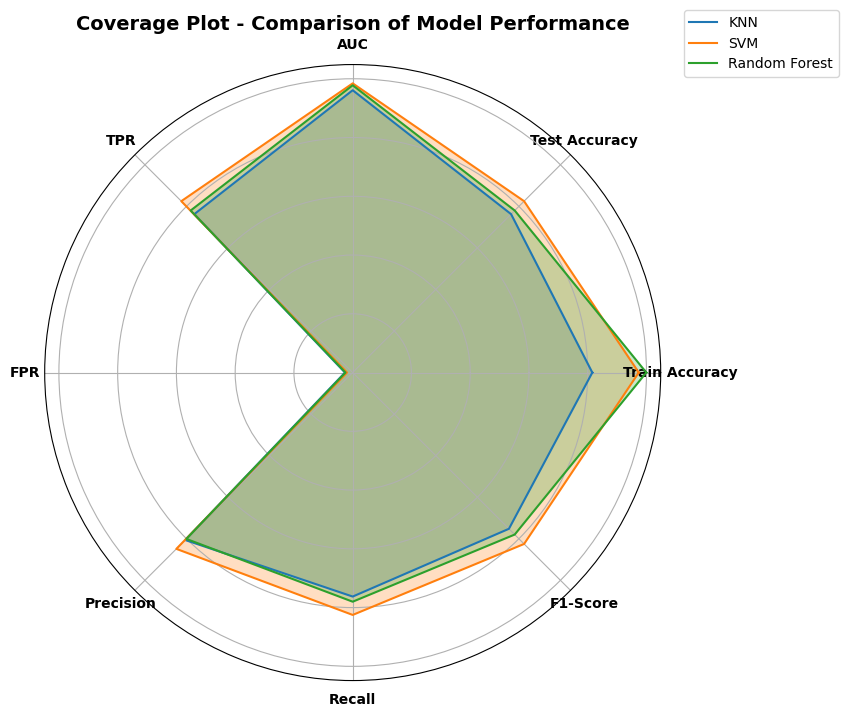

In [61]:
# Call the updated radar plot for model coverage
plot_coverage_radar(knn_results, svm_results, rf_results)